# Gradient Boosting Machine

- WANG Zhiwei, HKUST
- July 19th, 2022

In [1]:
# setwd("/import/home/zwanghc/Statistical Machine Learning/tutorial")
# getwd()

library(rpart)
library(repr)
library(ggplot2)

set.seed(20220719)

## Main function of GBT

In [2]:
# main function of GBT
GBT <- function(x, y, ntree = 3, shrinkage = 0.1, minsplit = 10, maxdepth = 5, loss = "squared") {
    n <- length(y)
    rpart_ctrl <- rpart.control(minsplit = minsplit, maxdepth = maxdepth)

    res <- matrix(0, n, ntree)
    pred <- matrix(0, n, ntree)
    yhat <- rep(0, n)
    trees <- list()
    x <- data.frame(x)
    x_name <- colnames(x)
    n_features <- length(x_name)
    imp_matrix <- matrix(, nrow = n_features, ncol = ntree)
    rownames(imp_matrix) <- x_name

    if (loss == "squared") {
        # initialize tree_0
        res_0 <- y
        tree_0 <- mean(res_0)
        pred_0 <- yhat <- rep(tree_0, n)

        for (t in 1:ntree) {
            res[, t] <- y - yhat
            dat <- data.frame(x, y = res[, t])
            # fit regression tree
            fit_tree <- rpart(y ~ ., dat, control = rpart_ctrl)
            pred[, t] <- predict(fit_tree, dat)
            yhat <- yhat + shrinkage * pred[, t]

            imp <- fit_tree$variable.importance
            if (!is.null(imp)) {
                imp_name <- names(imp)
                for (j in 1:length(imp)) {
                    imp_matrix[imp_name[j], t] <- imp[j]
                }
            }
            trees[[t]] <- fit_tree
        }
    }

    variable.importance <- rowSums(imp_matrix, na.rm = TRUE)
    variable.importance <- variable.importance / sum(variable.importance)

    ret <- list(
        yhat = yhat,
        res_0 = res_0,
        res = res,
        pred_0 = pred_0,
        pred = pred,
        tree_0 = tree_0,
        trees = trees,
        ntree = ntree,
        shrinkage = shrinkage,
        y = y,
        variable.importance = variable.importance,
        importance.matrix = imp_matrix
    )
    class(ret) <- "GBT"
    return(ret)
}

# prediction function for GBT object
predict.GBT <- function(object, x) {
    x <- data.frame(x)
    n <- dim(x)[1]

    pred <- rep(object$tree_0, n)
    for (t in 1:object$ntree) {
        pred <- pred + object$shrinkage * predict(object$trees[[t]], x)
    }

    return(pred)
}

# plot function for GBT object
plot.GBT <- function(object) {
    par(mfrow = c(3, object$ntree / 3))

    ymax <- max(object$y)
    ymin <- min(object$y)

    xs <- seq(0, 10, length.out = 500)
    ys <- 2 * sin(xs * 2) - 0.2 * xs

    plot(x, object$res_0, main = "tree0", ylim = range(y), ylab = "y")
    lines(x, object$pred_0, type = "s", col = "blue")

    for (t in 1:object$ntree) {
        plot(x, object$res[, t], main = paste0("tree", t), ylim = range(y), ylab = "y")
        lines(x, object$pred[, t], type = "s", col = "blue")
    }
}

# evaluate loss
eval.loss.GBT <- function(object, x, y) {
    x <- data.frame(x) # Predictor variables
    n <- length(y) # Sample size

    ntree <- object$ntree # Total tree number
    loss <- vector(, length = ntree + 1)

    pred <- rep(object$tree_0, n) # Tree_0 is the average value of training set
    loss[1] <- mean((y - pred)^2)

    for (t in 1:ntree) {
        pred <- pred + object$shrinkage * predict(object$trees[[t]], x)
        loss[t + 1] <- mean((y - pred)^2)
    }

    return(loss)
}

# cross validation
cv.GBT <- function(x, y, ntree_vec = c(0:12), nfold = 10, shrinkage = 1) {
    x <- data.frame(x)
    n <- length(y)
    idx <- ceiling(sample(1:n) / n * nfold)

    para_length <- length(ntree_vec)
    ntree_max <- ntree_vec[para_length]

    # report settings
    message("Info: Sample size: ", n)
    message("Info: Number of cv folds: ", nfold)

    test_loss <- matrix(0, nrow = nfold, ncol = para_length) # Row: fold; col: number of trees
    rownames(test_loss) <- paste0("fold_", 1:nfold)
    colnames(test_loss) <- paste0("ntree_", ntree_vec)

    cat("start cross validation process...... total", nfold, "validation sets \n")

    for (i in 1:nfold) {
        cat(i, "-th validation set... \n")

        x_train <- x[idx != i, ]
        y_train <- y[idx != i]

        x_test <- x[idx == i, ]
        y_test <- y[idx == i]


        fit_GBT <- GBT(x_train, y_train,
            ntree = ntree_max, shrinkage = shrinkage
        )

        loss_all <- eval.loss.GBT(fit_GBT, x_test, y_test)
        test_loss[i, ] <- loss_all[ntree_vec + 1]
    }

    cv_sd <- sqrt(apply(test_loss, MARGIN = 2, var) / (nfold - 1))
    cv_mean <- colMeans(test_loss)
    idx_min <- which.min(cv_mean)
    ntree_min <- ntree_vec[idx_min]

    if (ntree_min > 0) {
        fit_GBT <- GBT(x, y, ntree = ntree_min, shrinkage = shrinkage)
    } else {
        fit_GBT <- NULL
    }

    cv_GBT <- list(
        cv_mean = cv_mean,
        cv_sd = cv_sd,
        ntree_vec = ntree_vec,
        ntree_min = ntree_min,
        fit_GBT = fit_GBT,
        test_loss = test_loss
    )
    attr(cv_GBT, "class") <- "cv.GBT"

    message(
        "min test loss: ", cv_mean[idx_min],
        " is achieved at the ", ntree_min, "-th iteration, corresponding sd: ", cv_sd[idx_min]
    )

    return(cv_GBT)
}

# Visualize cross validation result
plot.cv.GBT <- function(object, width = 0.01, ...) {
    x <- object$ntree_vec
    y <- object$cv_mean

    upper <- y + object$cv_sd / 2
    lower <- y - object$cv_sd / 2
    ylim <- range(upper, lower)
    barw <- diff(range(x)) * width

    plot(x, y,
        ylim = ylim,
        type = "n",
        xlab = "Number of trees",
        ylab = "Squared loss", ...
    )

    segments(x, lower, x, upper, col = "darkgrey")
    segments(x - barw, lower, x + barw, lower, col = "darkgrey")
    segments(x - barw, upper, x + barw, upper, col = "darkgrey")
    points(x, y, col = "red", pch = 20)

    abline(v = object$ntree_min, lty = 3)
}

# cross validation for linear regression
cv.lm <- function(x, y, nfold = 10, center = FALSE, scale = FALSE) {
    x <- as.data.frame(x)
    n <- length(y)

    # Check standardization consistency
    if (!center & scale) {
        warning("Centering is required when 'scale' is TRUE. 'center' is automatically set to be TRUE.")
        center <- TRUE
    }

    # Centering, Scaling or do nothing
    if (!center) {
        # do nothing
    } else {
        y_m <- mean(y)
        y <- y - y_m
        x_m <- colMeans(x)
        x <- scale(x, center = TRUE, scale = FALSE)
        if (scale) {
            x_sd <- sqrt(colMeans(x^2))
            x_sd[which(x_sd == 0)] <- 1 # all x's are 0
            x <- apply(x, MARGIN = 1, function(x, sd) {
                x / sd
            }, sd = x_sd)
            x <- t(x)
        }
    }

    idx <- ceiling(sample(1:n) / n * nfold)

    # report settings
    message("Info: Sample size: ", n)
    message("Info: Number of cv folds: ", nfold)

    test_loss <- vector(, length = nfold)
    names(test_loss) <- paste0("fold_", 1:nfold)

    cat("start cross validation process...... total", nfold, "validation sets \n")

    for (i in 1:nfold) {
        cat(i, "-th validation set... \n")

        x_train <- x[idx != i, ]
        y_train <- y[idx != i]
        data_train <- data.frame(y = y_train, x_train)

        x_test <- as.data.frame(x[idx == i, ])
        y_test <- y[idx == i]


        fit_lm <- lm(y ~ ., data = data_train)

        pred <- predict(fit_lm, newdata = x_test)
        test_loss[i] <- mean((y_test - pred)^2)
    }

    cv_sd <- sqrt(var(test_loss) / (nfold - 1))
    cv_mean <- mean(test_loss)

    cv_lm <- list(
        cv_mean = cv_mean,
        cv_sd = cv_sd,
        test_loss = test_loss
    )
    attr(cv_lm, "class") <- "cv.lm"

    message("test loss mean: ", cv_mean, ", sd of mean: ", cv_sd)

    return(cv_lm)
}

## Simulation

In [3]:
n <- 100

x <- sort(runif(n,min=0,max=10))
y <- 2*sin(x*2)-0.2*x

fit_GBT <- GBT(x,y,shrinkage = 1,ntree = 11)

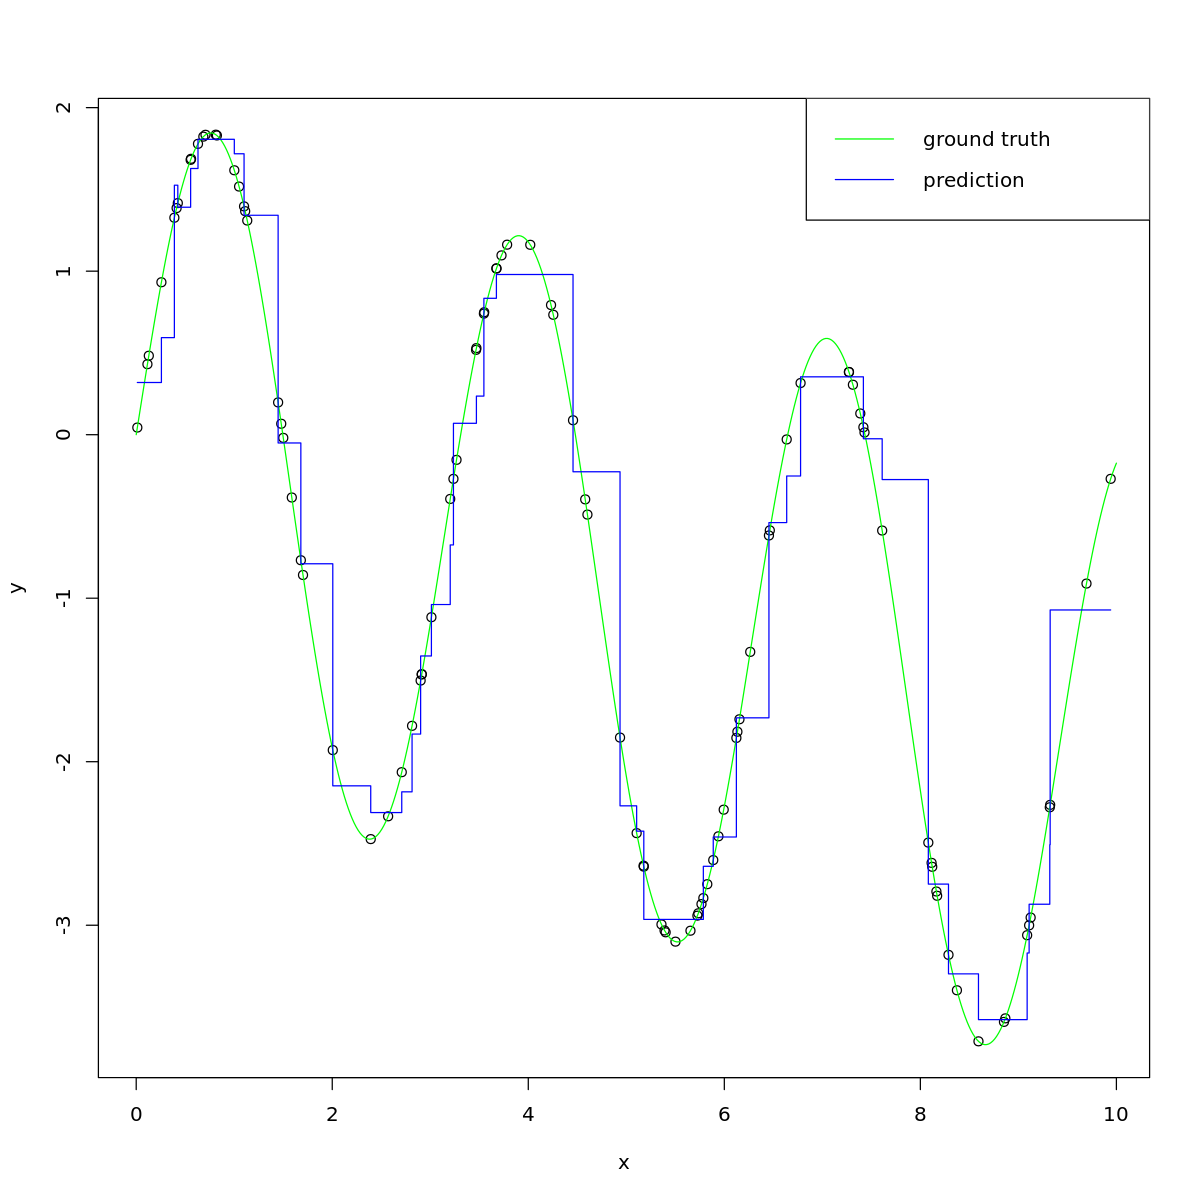

In [4]:
options(repr.plot.width=10, repr.plot.height=10)
xs <- seq(0,10,length.out = 500)
ys <- 2*sin(xs*2)-0.2*xs
plot(x,y)
lines(xs,ys,col="green")
lines(x,predict(fit_GBT,x),type="s",col="blue")
legend("topright", legend = c("ground truth", "prediction"),
       col=c("green", "blue"),lty=1)

### Training loss

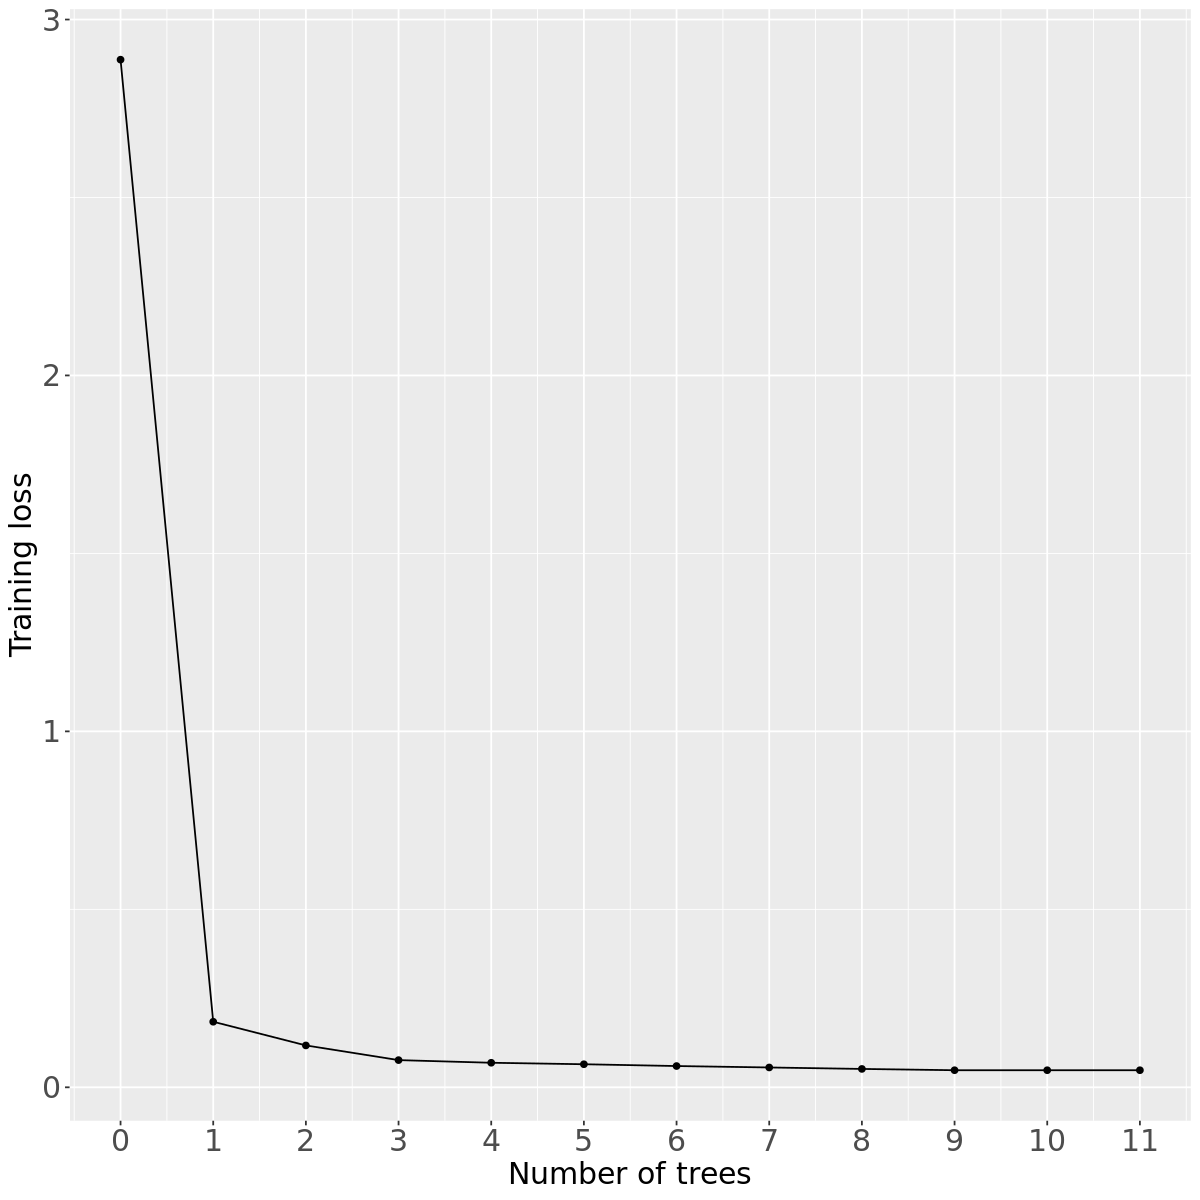

In [5]:
loss <- eval.loss.GBT(fit_GBT, x, y)
ggplot(data = NULL, aes(x = 0:fit_GBT$ntree, y = loss)) +
    geom_line() +
    geom_point() +
    scale_x_continuous(breaks = c(0:fit_GBT$ntree)) +
    xlab("Number of trees") +
    ylab("Training loss") +
    theme(text = element_text(size = 18), 
          axis.title = element_text(size = 18), 
          axis.text.y = element_text(size = 18), 
          axis.text.x = element_text(size = 18))

### Test loss

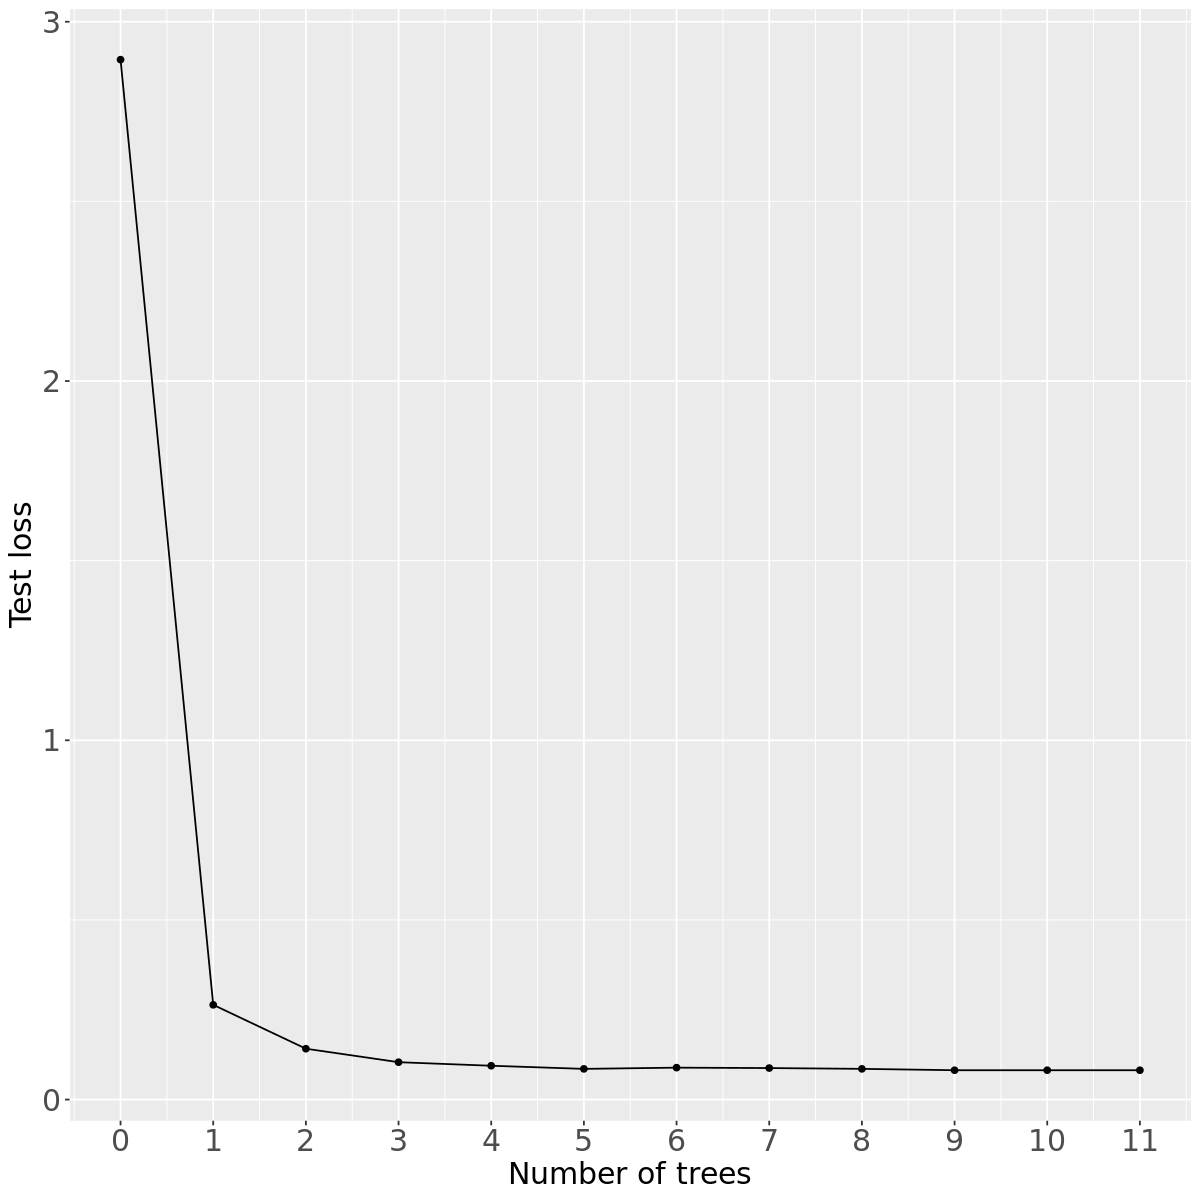

In [6]:
x_new <- sort(runif(n,min=0,max=10))
y_new <- 2*sin(x_new*2)-0.2*x_new

loss <- eval.loss.GBT(fit_GBT, x_new, y_new)

ggplot(data = NULL, aes(x = 0:fit_GBT$ntree, y = loss)) +
    geom_line() +
    geom_point() +
    scale_x_continuous(breaks = c(0:fit_GBT$ntree)) +
    xlab("Number of trees") +
    ylab("Test loss") +
    theme(text = element_text(size = 18), 
          axis.title = element_text(size = 18), 
          axis.text.y = element_text(size = 18), 
          axis.text.x = element_text(size = 18))

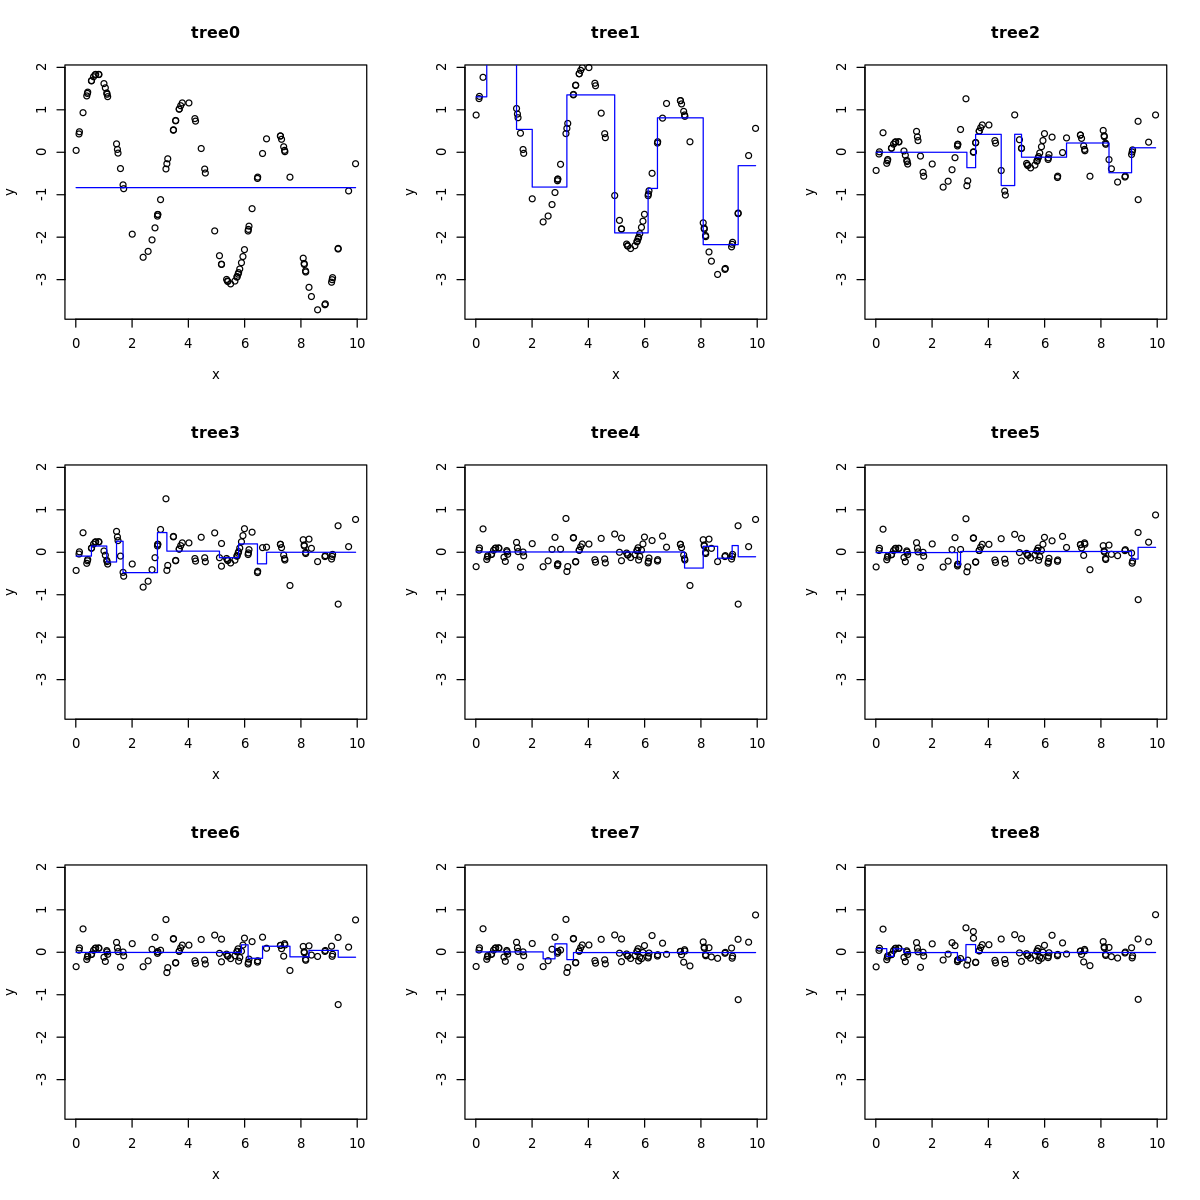

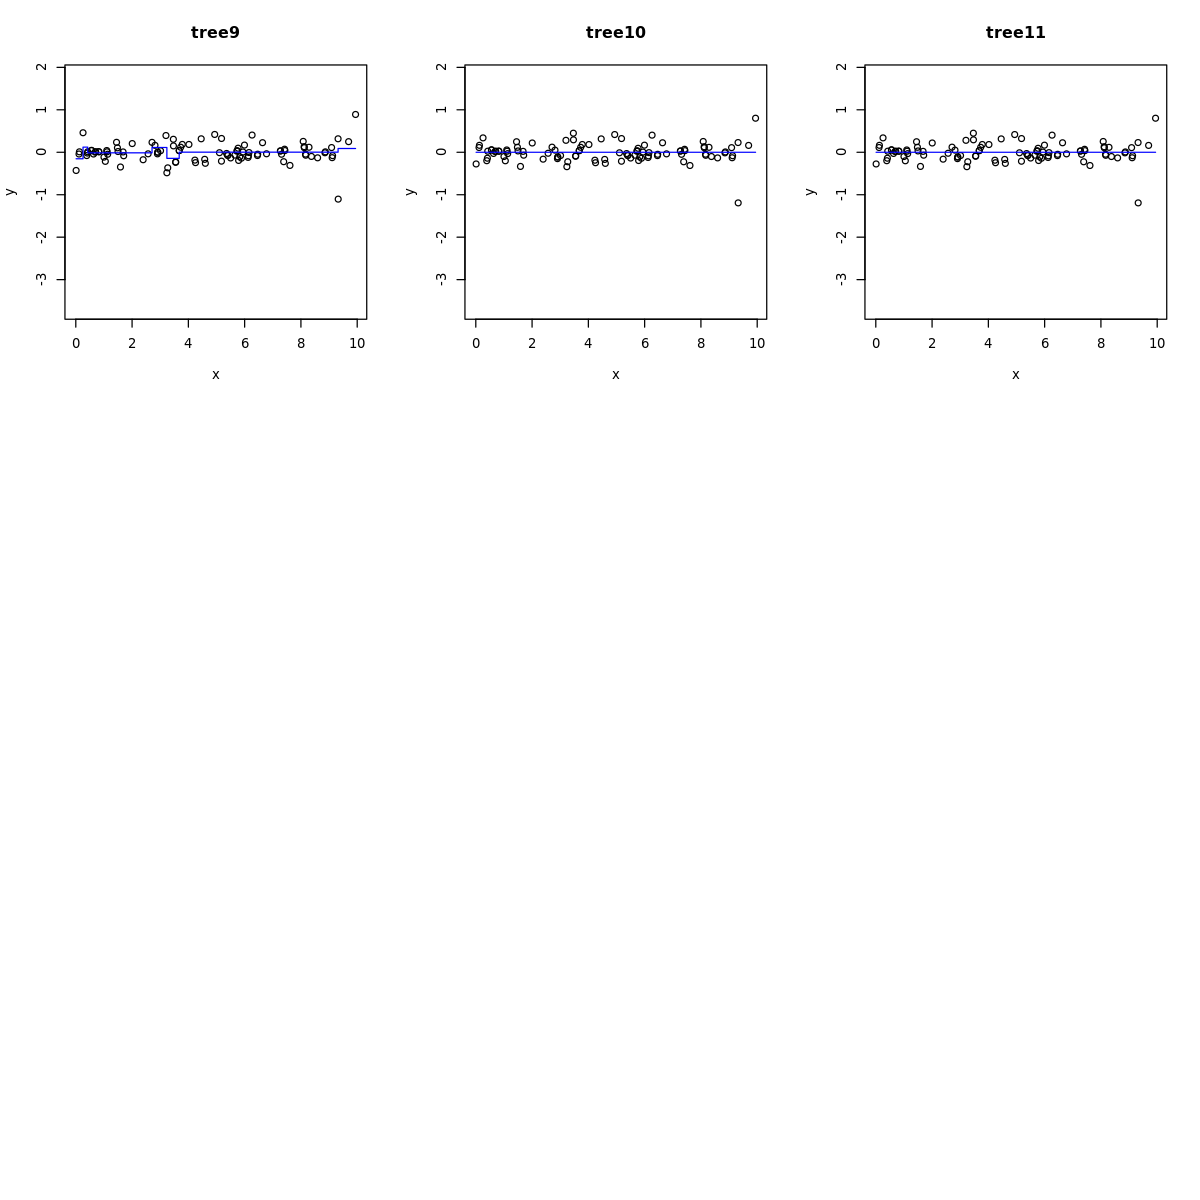

In [7]:
options(repr.plot.width=10, repr.plot.height=10)
plot(fit_GBT)

In [8]:
dim(fit_GBT$res)

[1] 100  11

In [9]:
colSums((fit_GBT$res)^2/n)

[1] 2.88724179 0.18421503 0.11768155 0.07643153 0.06900122 0.06482982
 [7] 0.05978506 0.05576135 0.05165553 0.04802988 0.04802988

## Observation with noise

In [10]:
SNR <- 3 # signal noise ratio

x <- sort(runif(n,min=0,max=10))
y <- 2*sin(x*2)-0.2*x

noise_sd <- sqrt(var(y) / SNR)
noise <- rnorm(n, sd = noise_sd)

y <- y + noise # add Gaussian noise

fit_GBT <- GBT(x,y,shrinkage = 1,ntree = 11)

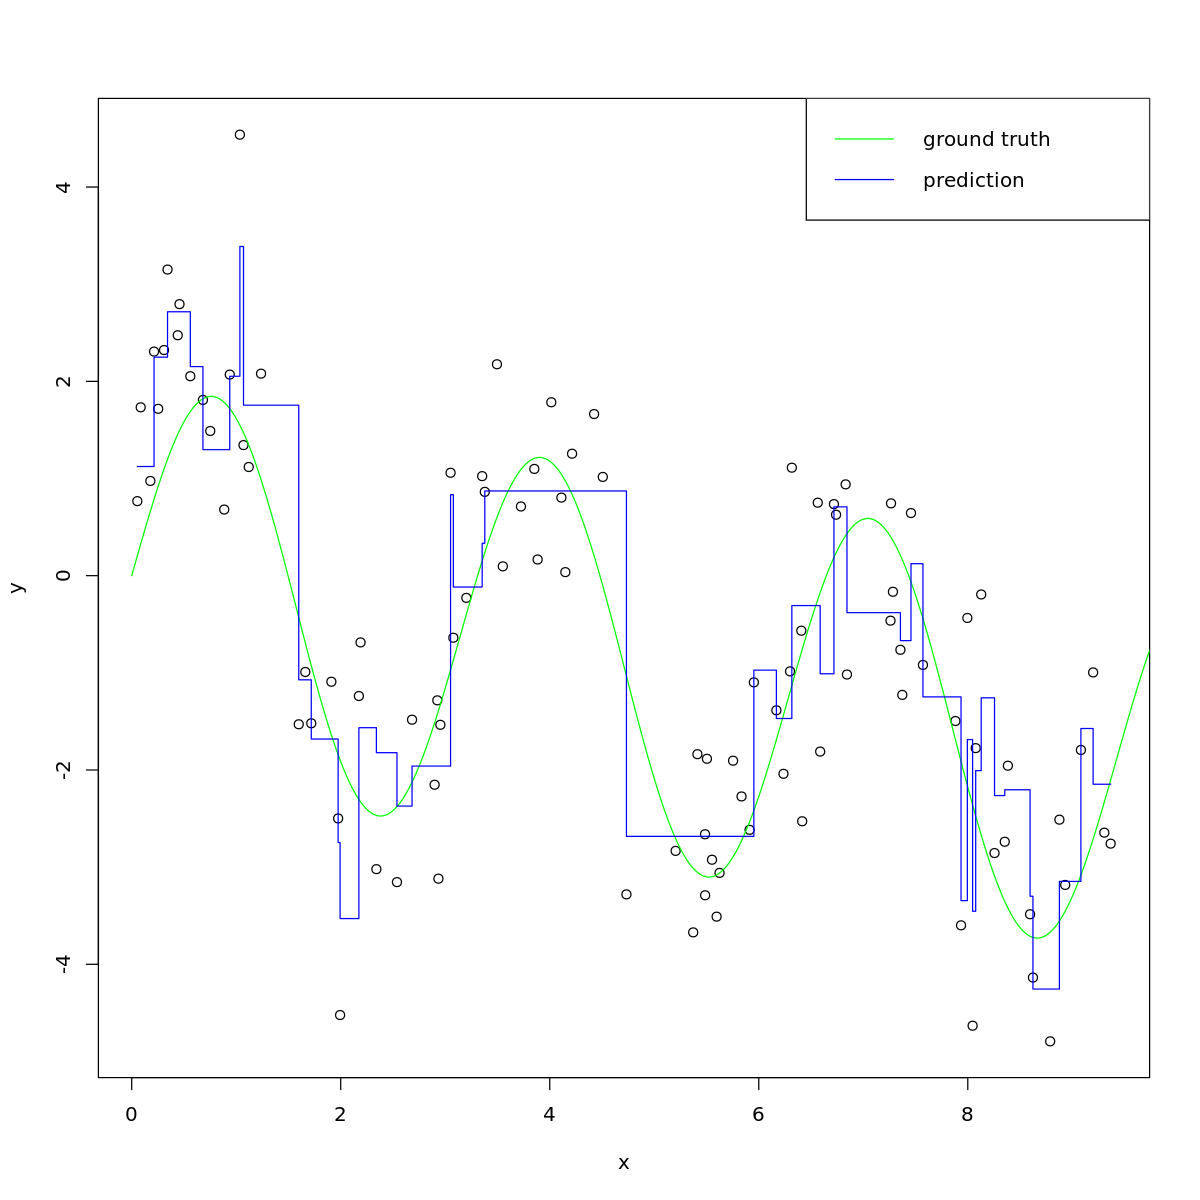

In [11]:
options(repr.plot.width=10, repr.plot.height=10)
xs <- seq(0,10,length.out = 500)
ys <- 2*sin(xs*2)-0.2*xs
plot(x,y)
lines(xs,ys,col="green")
lines(x,predict(fit_GBT,x),type="s",col="blue")
legend("topright",legend=c("ground truth", "prediction"),
       col=c("green", "blue"),lty=1)

### Training loss

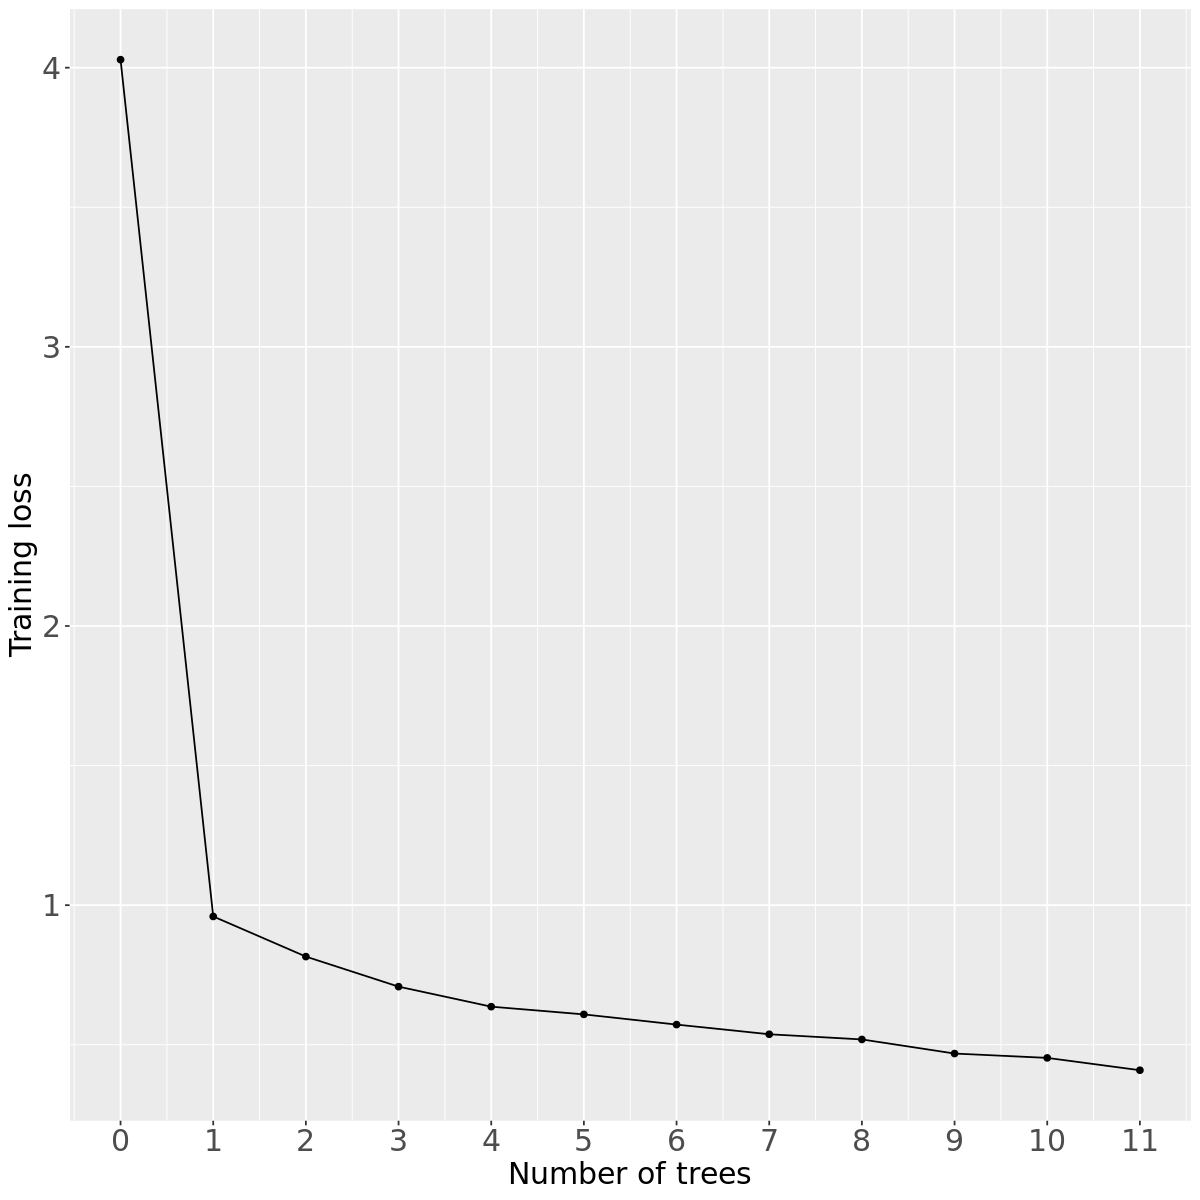

In [12]:
loss <- eval.loss.GBT(fit_GBT, x, y)
ggplot(data = NULL, aes(x = 0:fit_GBT$ntree, y = loss)) +
    geom_line() +
    geom_point() +
    scale_x_continuous(breaks = c(0:fit_GBT$ntree)) +
    xlab("Number of trees") +
    ylab("Training loss") +
    theme(text = element_text(size = 18), 
          axis.title = element_text(size = 18), 
          axis.text.y = element_text(size = 18), 
          axis.text.x = element_text(size = 18))

### Test loss

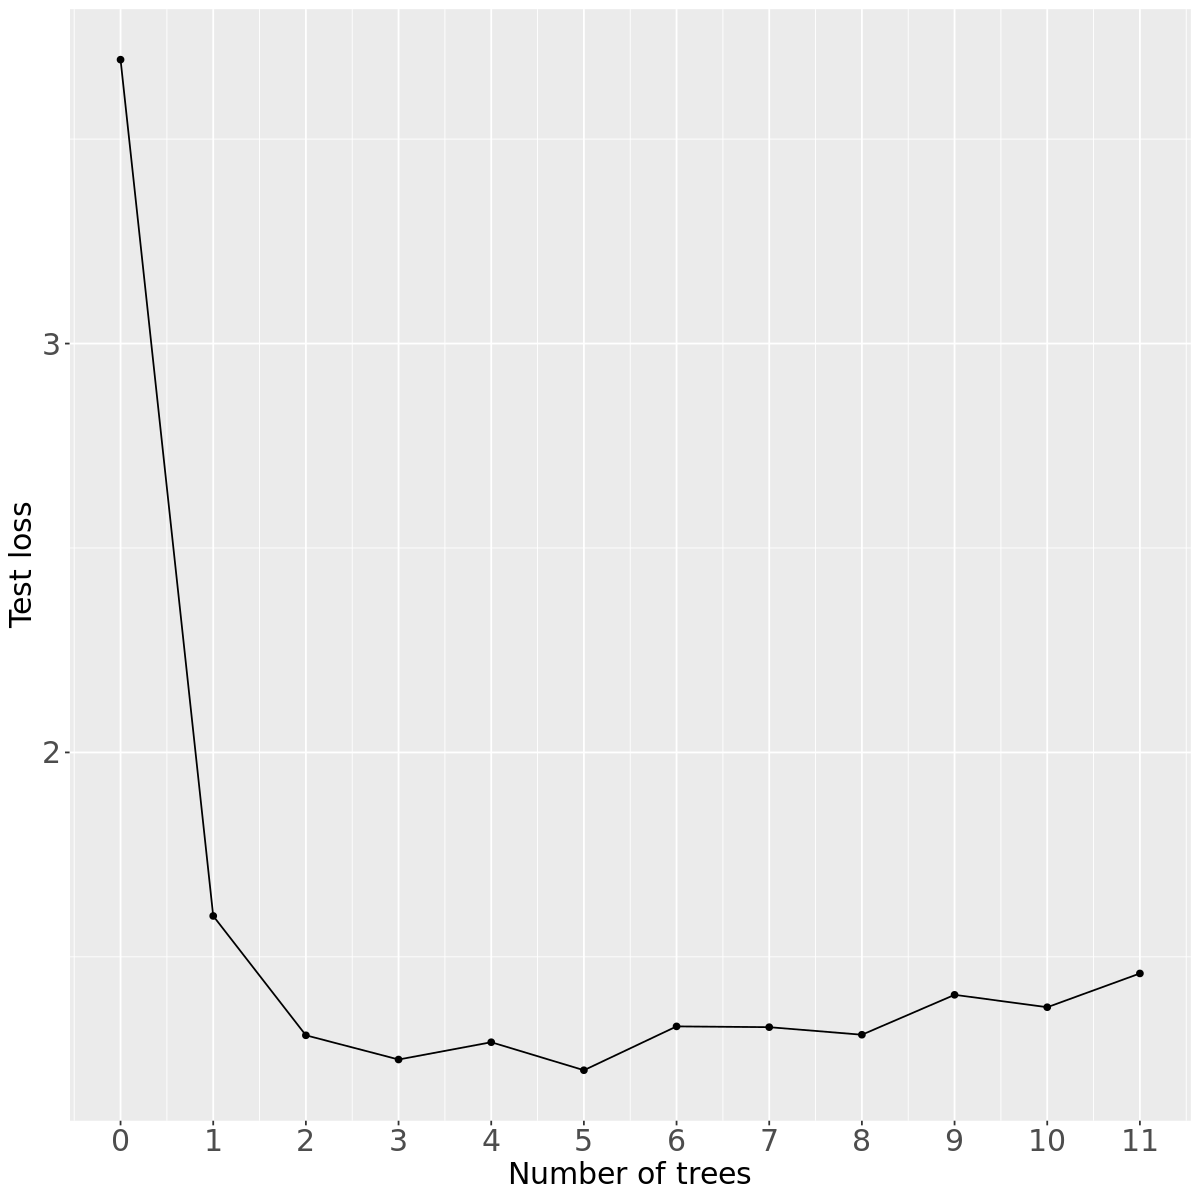

In [13]:
x_new <- sort(runif(n,min=0,max=10))
y_new <- 2*sin(x_new*2)-0.2*x_new + rnorm(n, sd = noise_sd)

loss <- eval.loss.GBT(fit_GBT, x_new, y_new)

ggplot(data = NULL, aes(x = 0:fit_GBT$ntree, y = loss)) +
    geom_line() +
    geom_point() +
    scale_x_continuous(breaks = c(0:fit_GBT$ntree)) +
    xlab("Number of trees") +
    ylab("Test loss") +
    theme(text = element_text(size = 18), 
          axis.title = element_text(size = 18), 
          axis.text.y = element_text(size = 18), 
          axis.text.x = element_text(size = 18))

### Use relatively small learning rate

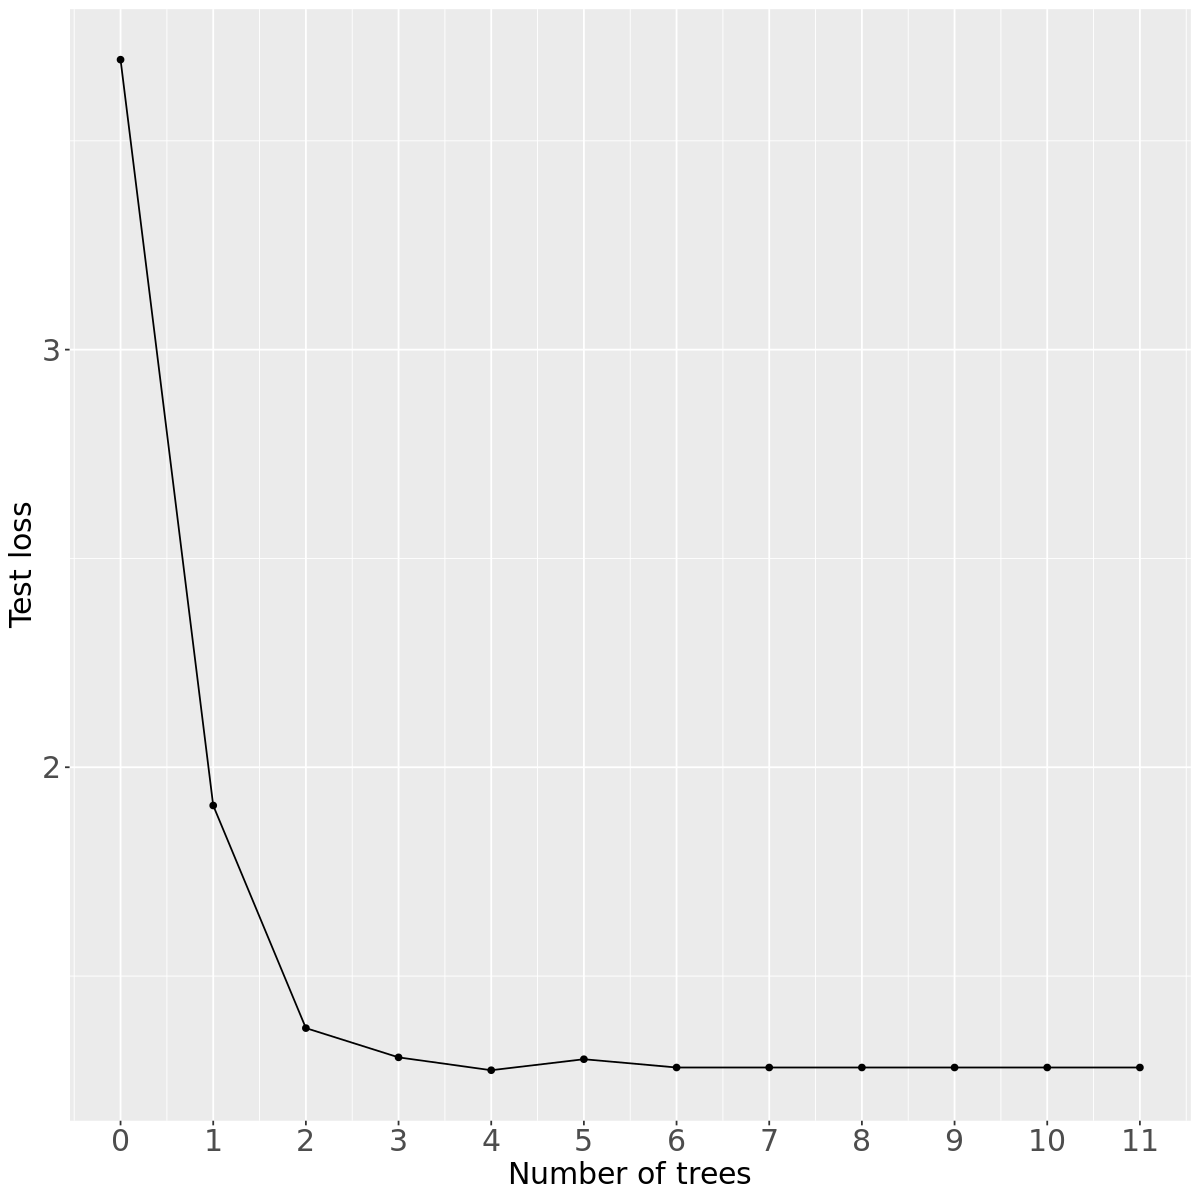

In [14]:
fit_GBT <- GBT(x, y, shrinkage = 0.5, ntree = 11)

# test loss
loss <- eval.loss.GBT(fit_GBT, x_new, y_new)

ggplot(data = NULL, aes(x = 0:fit_GBT$ntree, y = loss)) +
    geom_line() +
    geom_point() +
    scale_x_continuous(breaks = c(0:fit_GBT$ntree)) +
    xlab("Number of trees") +
    ylab("Test loss") +
    theme(text = element_text(size = 18), axis.title = element_text(size = 18), axis.text.y = element_text(size = 18), axis.text.x = element_text(size = 18))

## Cross validation

Info: Sample size: 100

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 0.990563756133361 is achieved at the 26-th iteration, corresponding sd: 0.0853833796303534



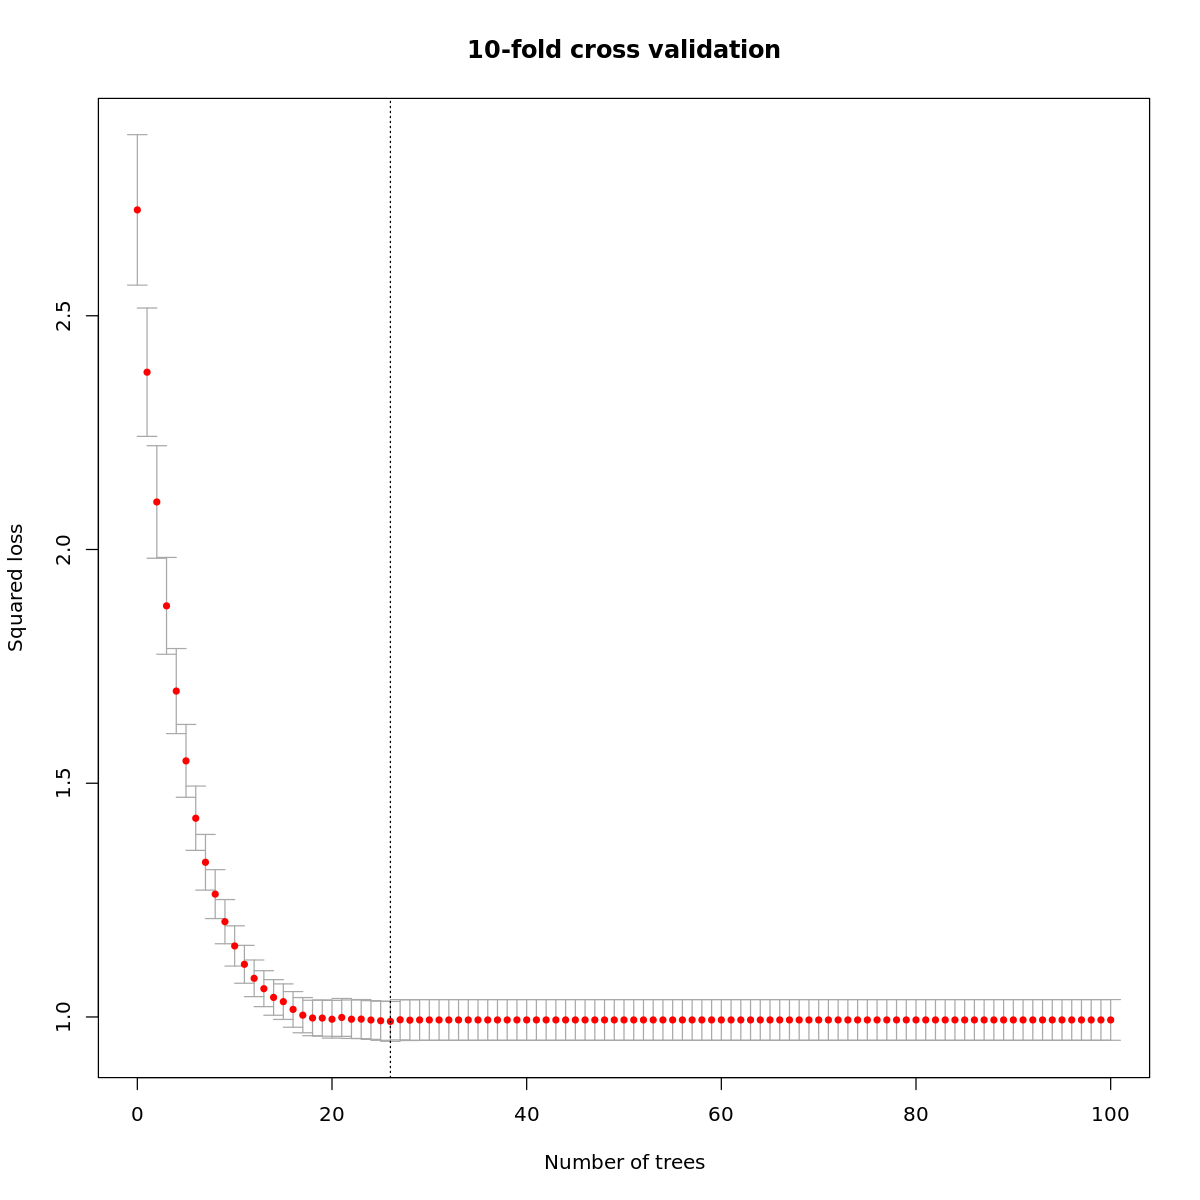

In [15]:
SNR <- 3 # signal noise ratio

x <- sort(runif(n,min=0,max=10))
y <- 2*sin(x*2)-0.2*x

noise_sd <- sqrt(var(y) / SNR)
noise <- rnorm(n, sd = noise_sd)

y <- y + noise # add Gaussian noise

GBT_nfold_10 <- cv.GBT(x, y, ntree_vec = c(0:100), nfold = 10, shrinkage = 0.1)
plot(GBT_nfold_10, main = "10-fold cross validation")

## Variable importance

In [16]:
# Use a spase model to check variable importance
N = 200
n_variable = 20 # number of variables
X = matrix(runif(N*n_variable, min = -10, max = 10), N, n_variable)
colnames(X) <- x_name <- paste0("x", c(1:n_variable))
x_name <- factor(x_name, levels = x_name)
    
# gamma <- rep(0, n_variable)
# gamma[1] <- rnorm(1, mean = 10, sd = 1)
# gamma[2] <- rnorm(1, mean = -20, sd = 1)
    
y = as.vector(X[, 1]^2 - 5 * X[, 2] + 0.1 * X[, 3]^3)

fit_GBT <- GBT(X, y, shrinkage = 1, ntree = 11)

In [17]:
var(X[, 1]^2)
var(5 * X[, 2])
var(0.1 * X[, 3]^3)

[1] 810.2201

[1] 754.333

[1] 1363.875

In [18]:
fit_GBT$variable.importance

x1          x2          x3          x4          x5          x6 
0.136129259 0.151915913 0.353371294 0.018128439 0.045687381 0.023021038 
         x7          x8          x9         x10         x11         x12 
0.010894872 0.019517699 0.023038538 0.038996577 0.017676752 0.014008858 
        x13         x14         x15         x16         x17         x18 
0.036150477 0.014801245 0.020363719 0.014175849 0.014805387 0.023017975 
        x19         x20 
0.014864384 0.009434343

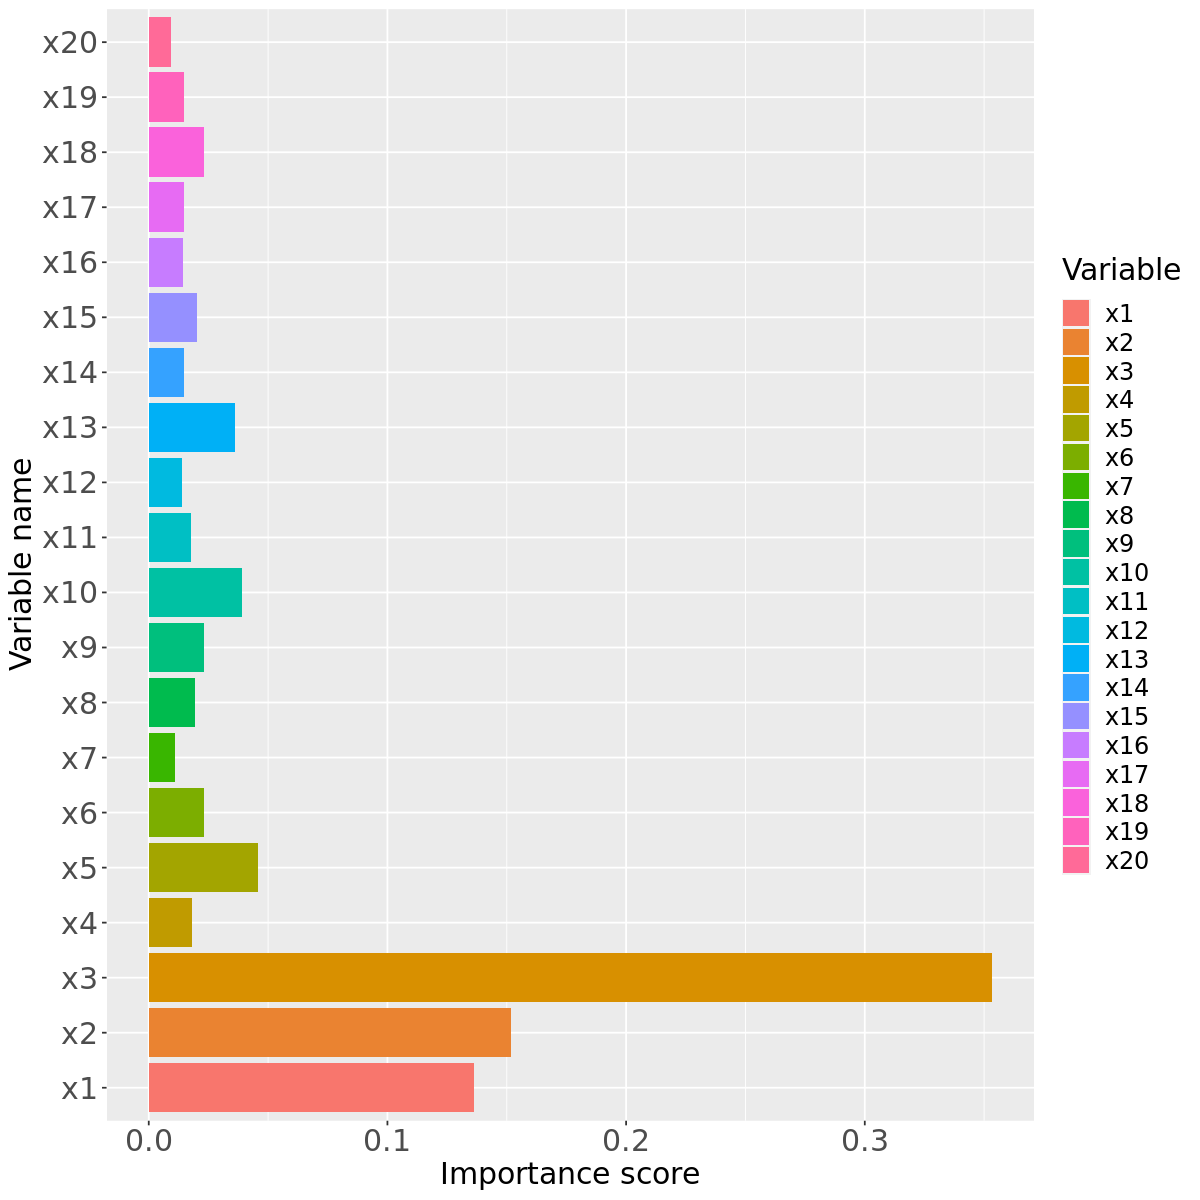

In [19]:
ggplot(data = NULL, aes(x = x_name, y = fit_GBT$variable.importance, fill = x_name)) +
    geom_col() +
    xlab("Variable name") +
    ylab("Importance score") +
    guides(fill = guide_legend(title = "Variable")) +
    theme(text = element_text(size = 18), 
          axis.title = element_text(size = 18), 
          axis.text.y = element_text(size = 18), 
          axis.text.x = element_text(size = 18)) +
    coord_flip()

## Real data example

### Auto MPG dataset

In [20]:
# install.packages("ISLR2")
library(ISLR2)

data(Auto)
dim(Auto)
sum(is.na(Auto))
head(Auto)

[1] 392   9

[1] 0

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<fct>
1,18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
2,15,8,350,165,3693,11.5,70,1,buick skylark 320
3,18,8,318,150,3436,11.0,70,1,plymouth satellite
4,16,8,304,150,3433,12.0,70,1,amc rebel sst
5,17,8,302,140,3449,10.5,70,1,ford torino
6,15,8,429,198,4341,10.0,70,1,ford galaxie 500


#### Gradient boosting

We set `ntree_vec = c(1:100)` for all the settings of the learning rate `shrinkage`

In [21]:
# x <- Auto[, c(2:9)]
x <- Auto[, c(2:8)]
x[, 7] <- as.factor(x[, 7])
# x[, 8] <- as.factor(x[, 8])
# head(x)

y <- Auto[, 1]
# y

Info: Sample size: 392

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 8.06261812564422 is achieved at the 48-th iteration, corresponding sd: 0.743830297656856



GBT finished!


Info: Sample size: 392

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 7.68536565942048 is achieved at the 15-th iteration, corresponding sd: 1.25069324205114



GBT finished!


Info: Sample size: 392

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 9.36265992194003 is achieved at the 12-th iteration, corresponding sd: 0.680584592358017



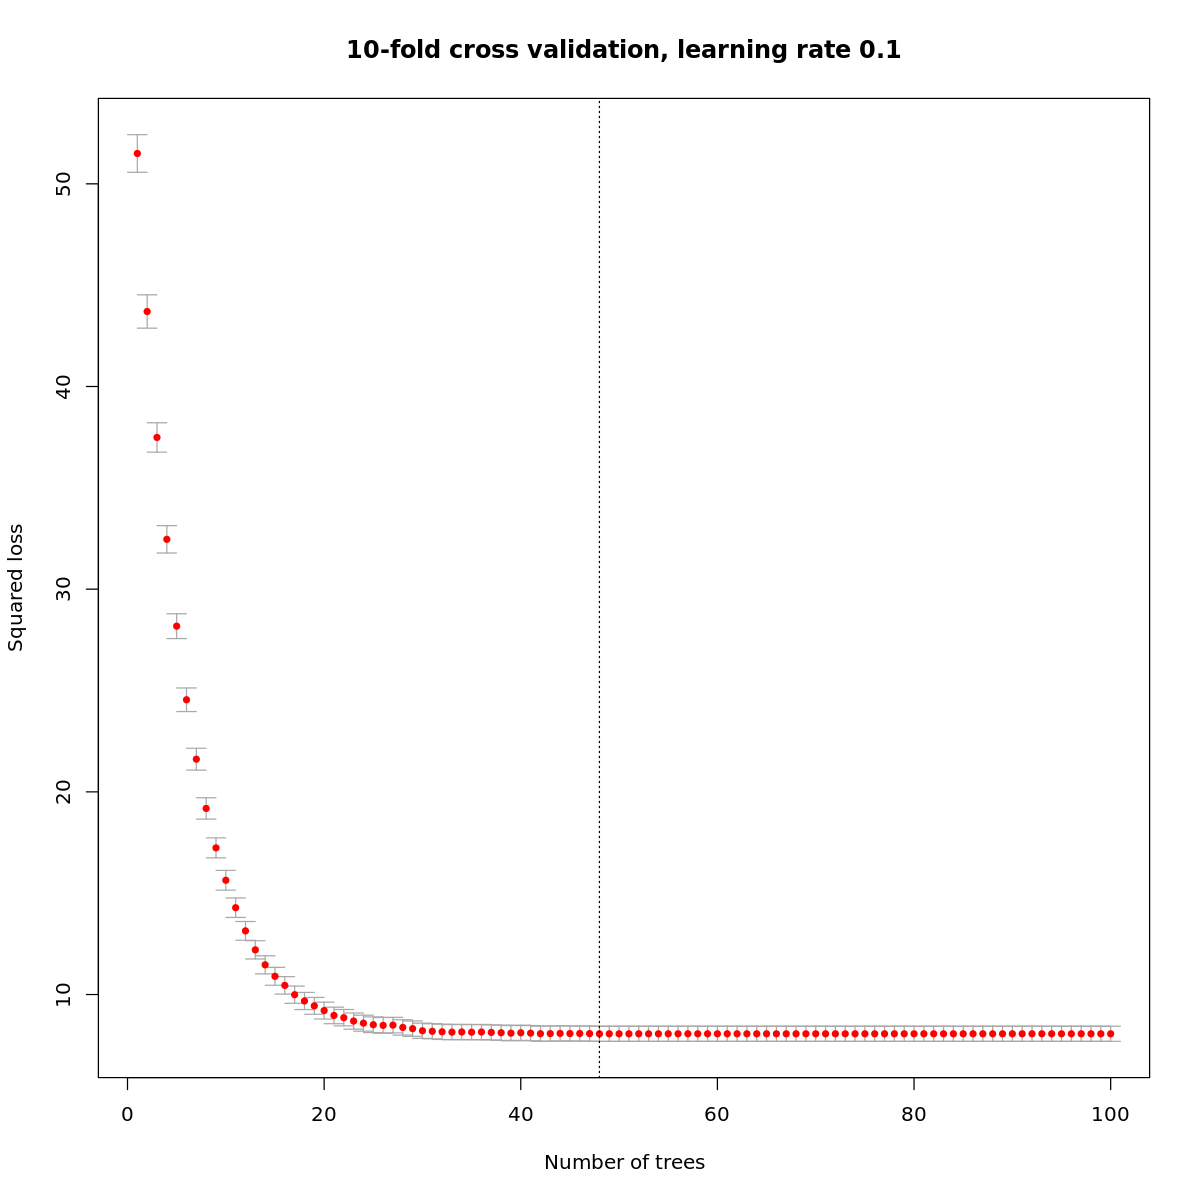

GBT finished!


Info: Sample size: 392

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 9.63442794889247 is achieved at the 6-th iteration, corresponding sd: 1.16895062551275



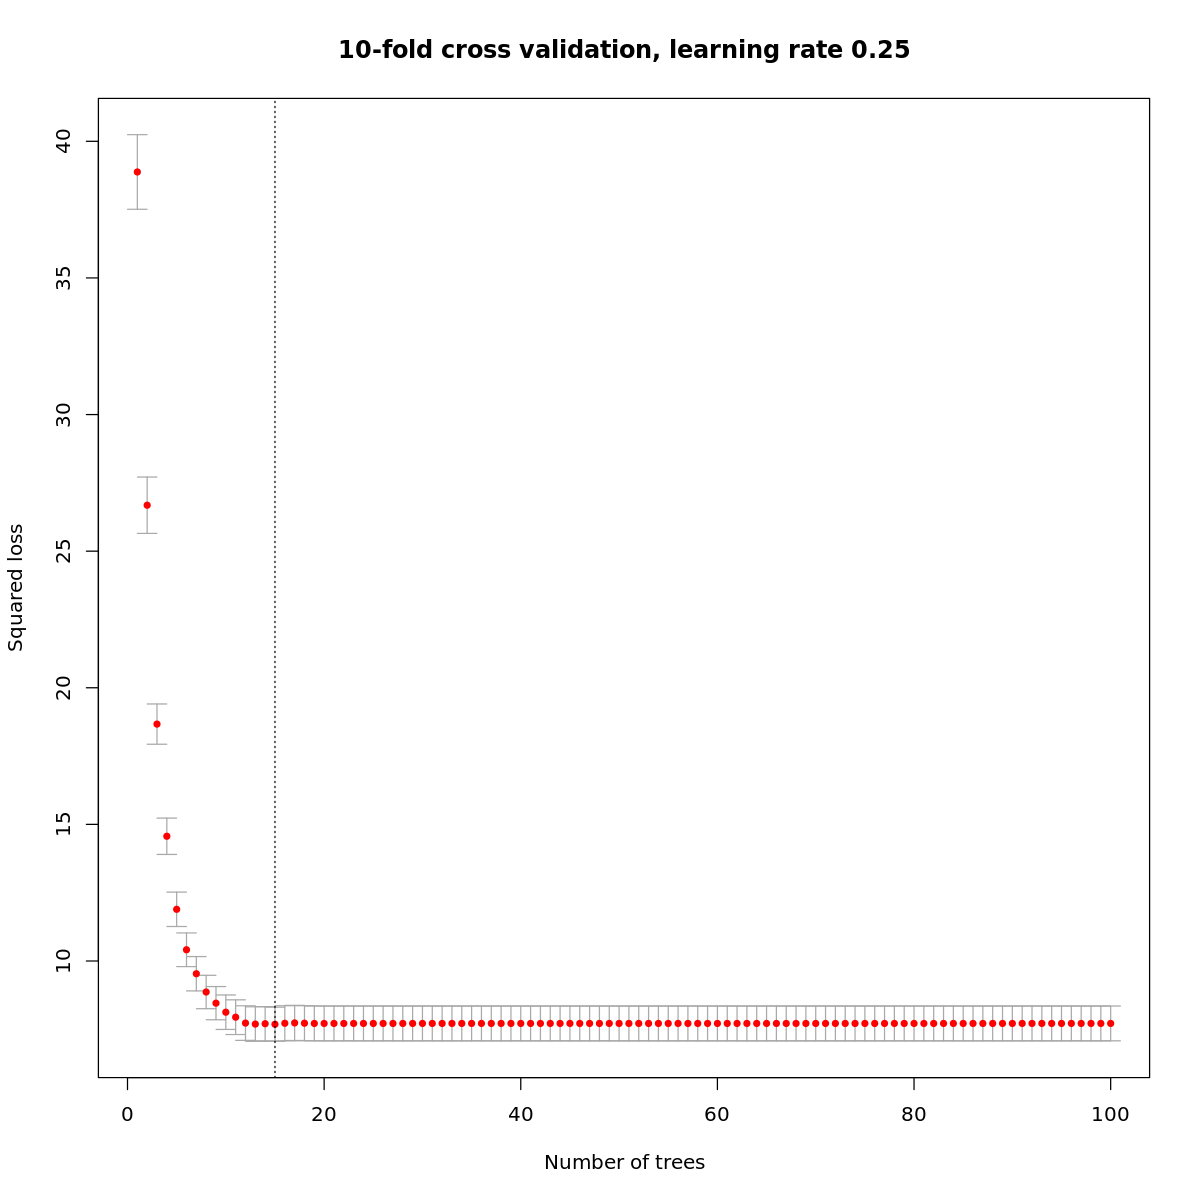

GBT finished!


Info: Sample size: 392

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 10.707606568122 is achieved at the 10-th iteration, corresponding sd: 1.48767502096741



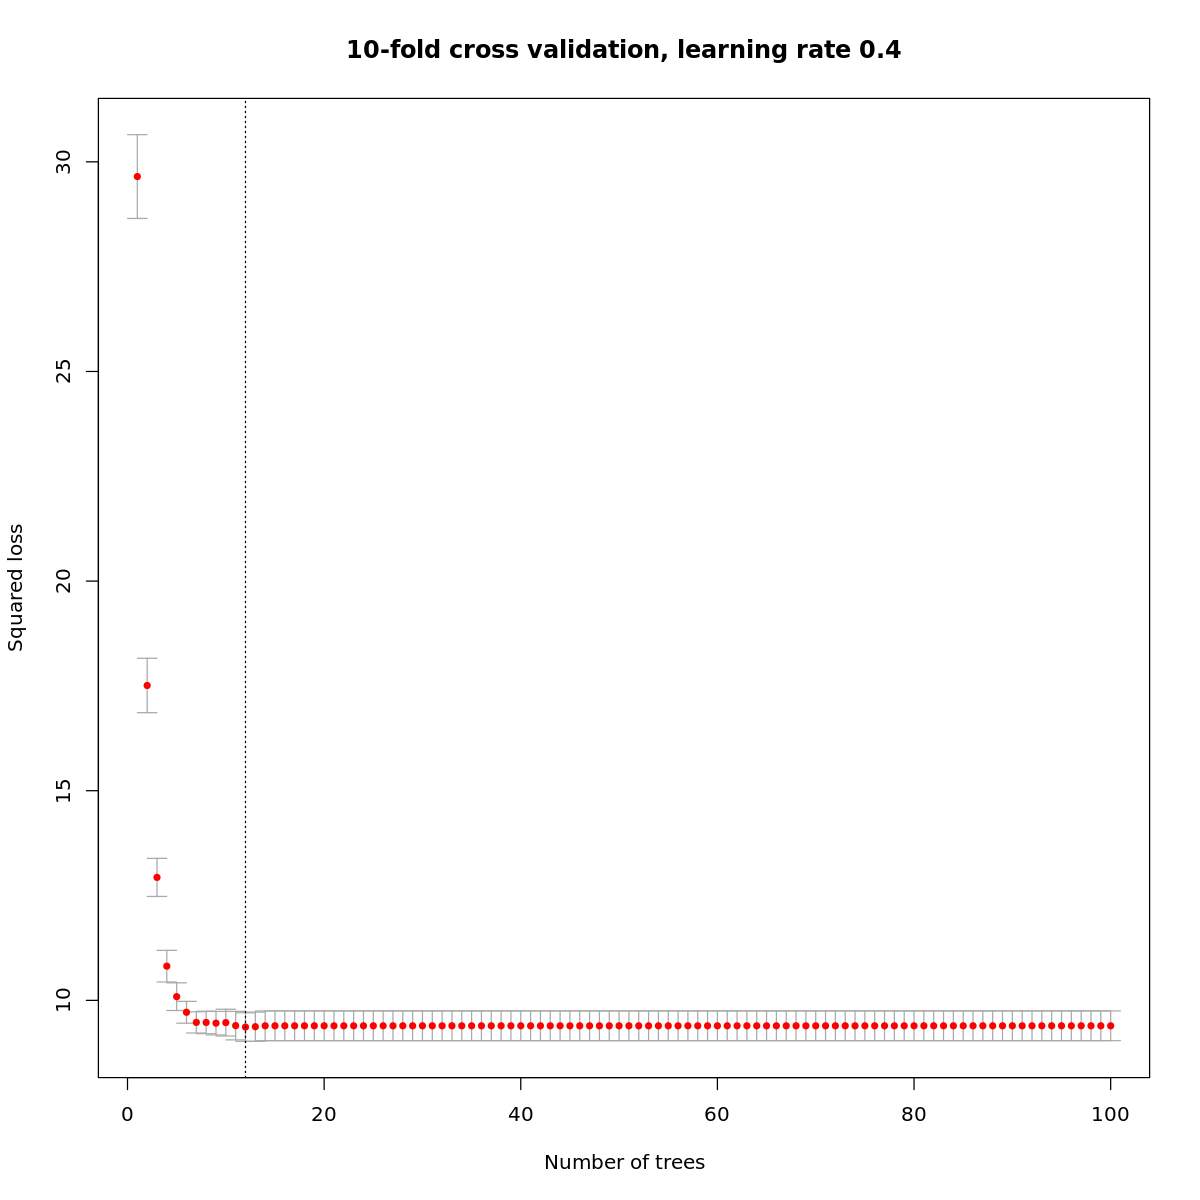

GBT finished!


Info: Sample size: 392

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 11.1818762438757 is achieved at the 9-th iteration, corresponding sd: 1.01832357147486



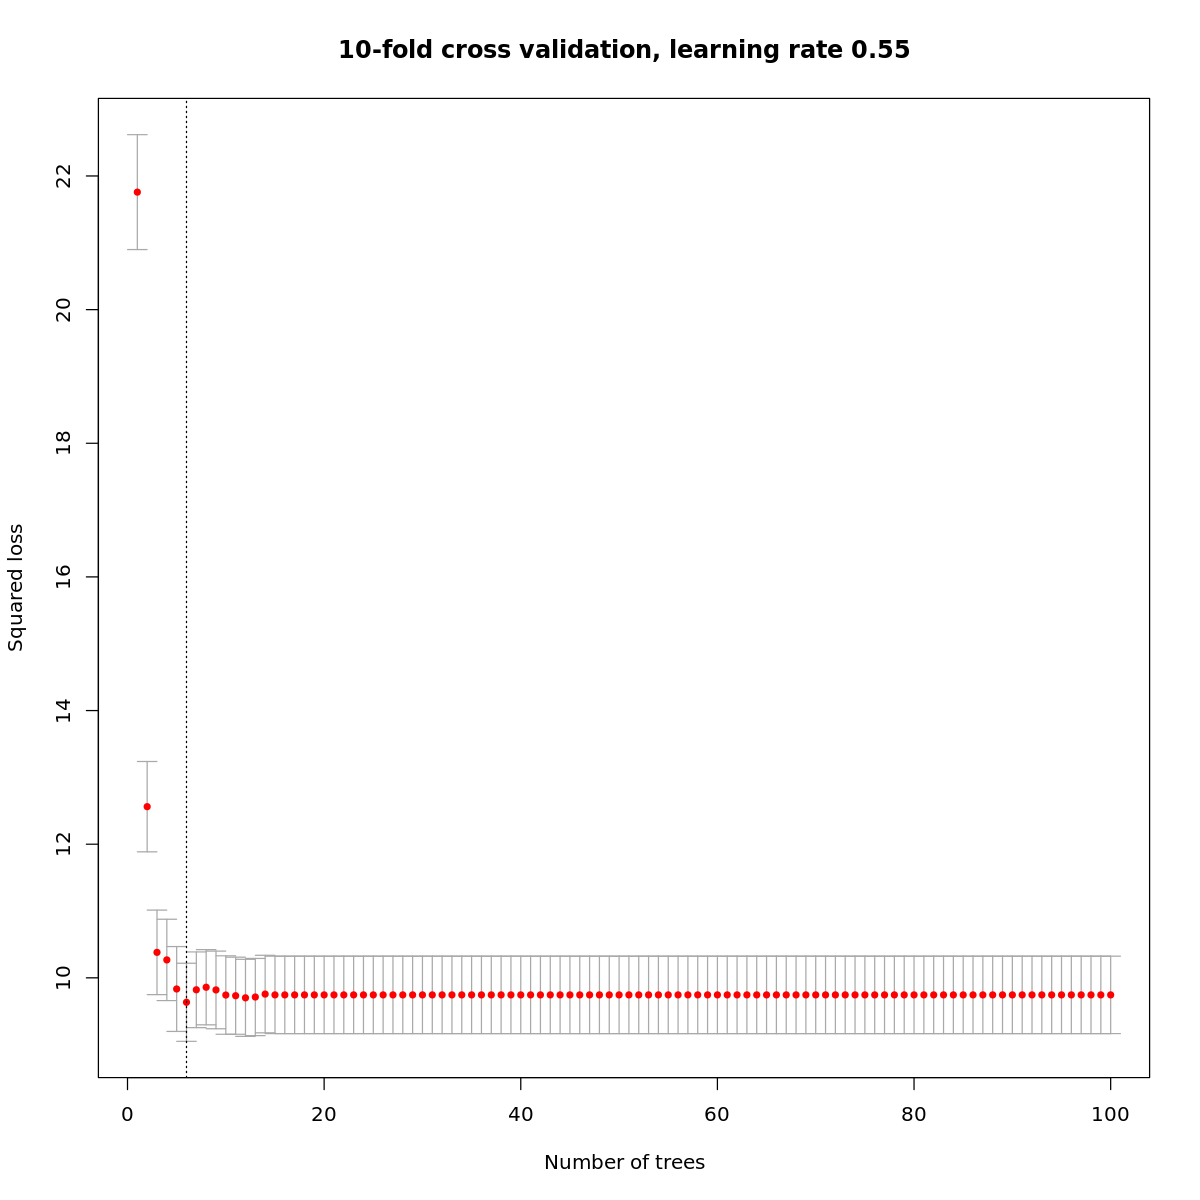

GBT finished!


Info: Sample size: 392

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 11.9170294043583 is achieved at the 5-th iteration, corresponding sd: 1.28344624104839



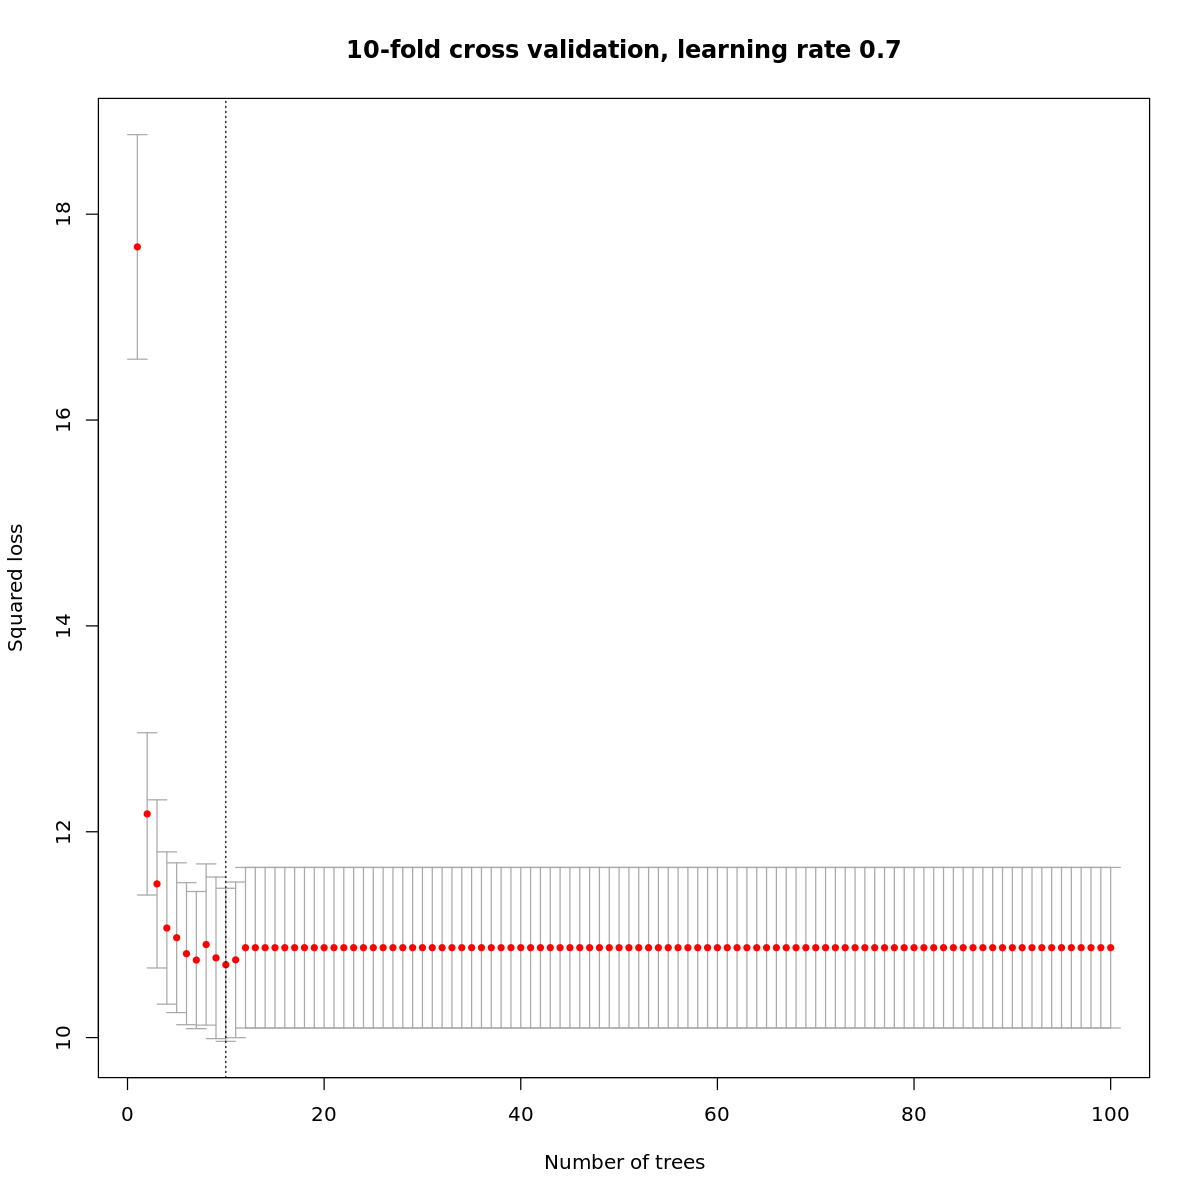

GBT finished!


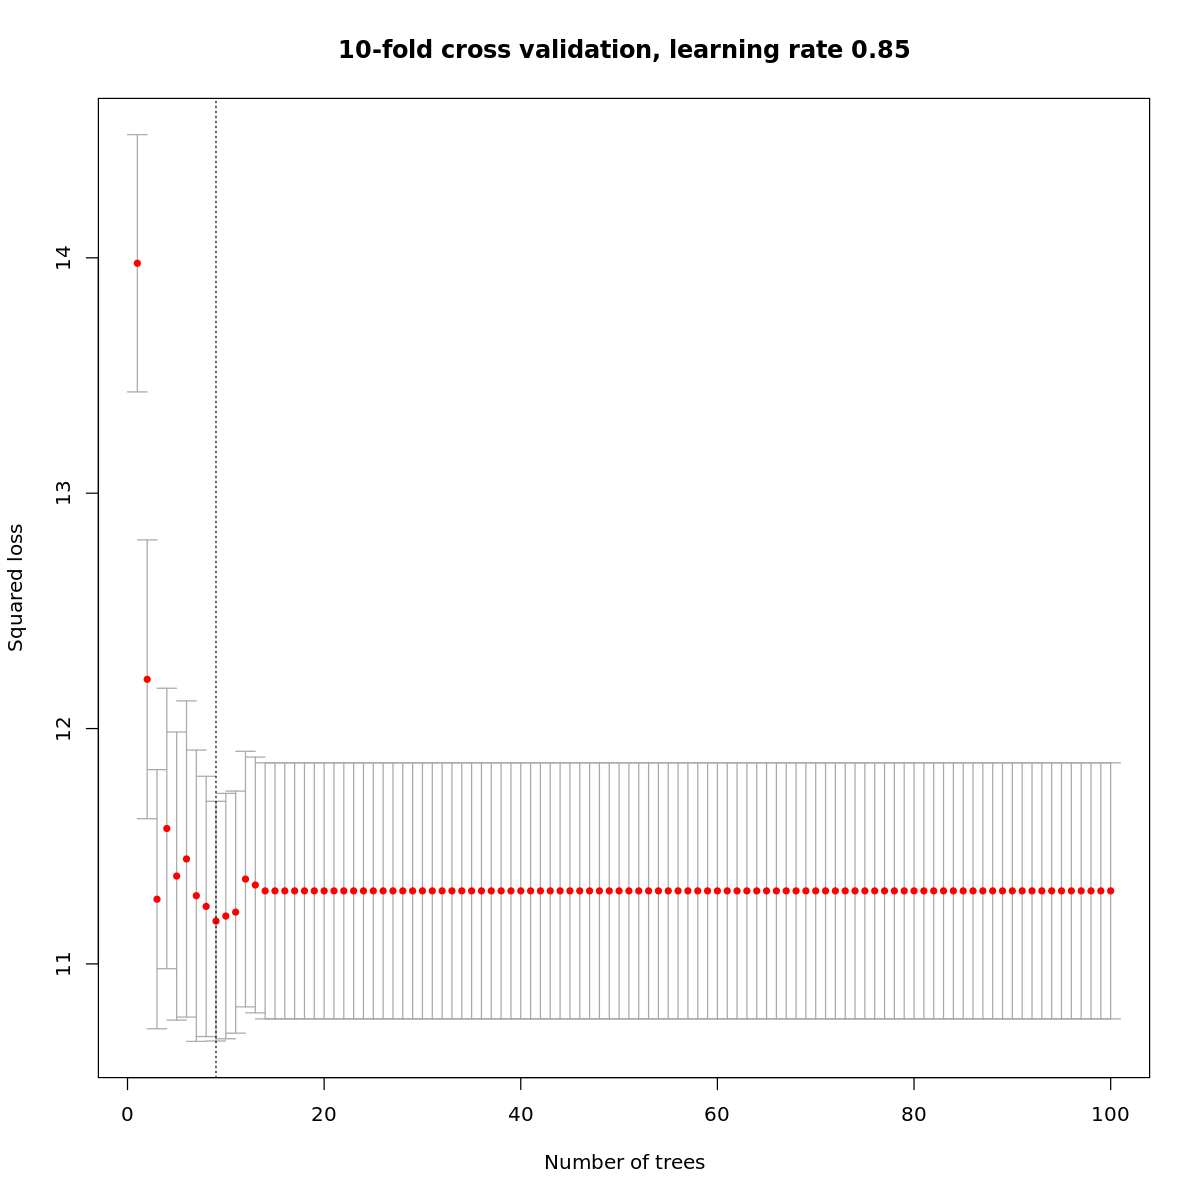

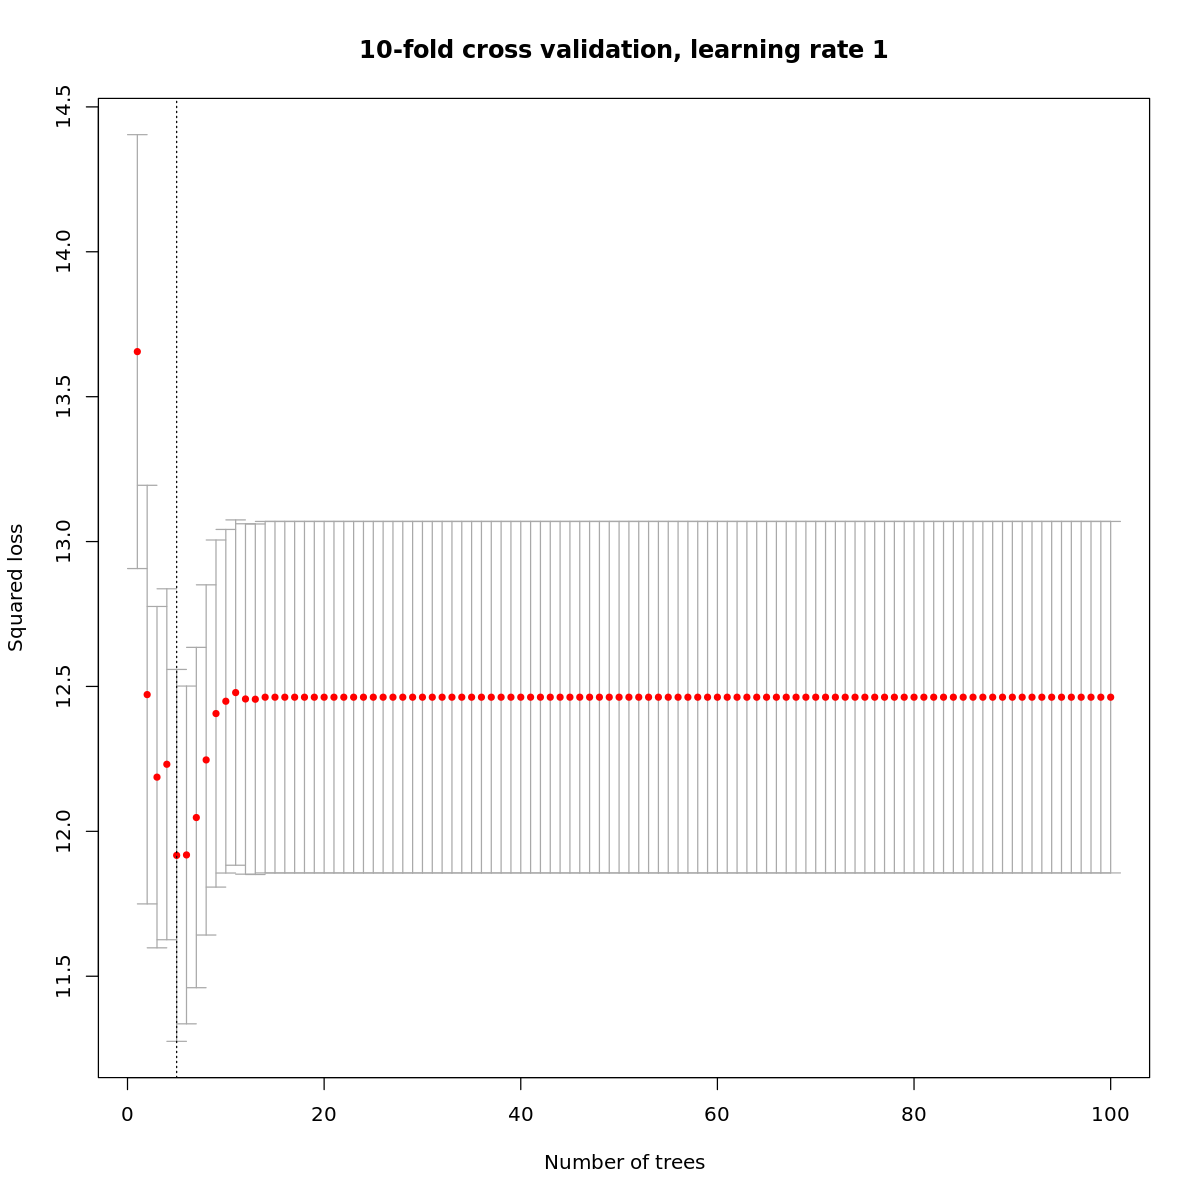

In [22]:
shrinkage_list <- seq(from = 0.1, to = 1, by = 0.15)
for(shrinkage in shrinkage_list){
    GBT_nfold_10 <- cv.GBT(x, y, ntree_vec = c(1:100), nfold = 10, shrinkage = shrinkage)
    cat("GBT finished!\n")
    plot(GBT_nfold_10, main = paste0("10-fold cross validation, learning rate ", shrinkage))
}

#### Variable importance

In [23]:
fit_GBT <-  GBT(x, y, shrinkage = 0.2, ntree = 20)
fit_GBT$variable.importance

cylinders displacement   horsepower       weight acceleration         year 
  0.17563911   0.21172361   0.17454997   0.20723124   0.08065641   0.04692434 
      origin 
  0.10327532

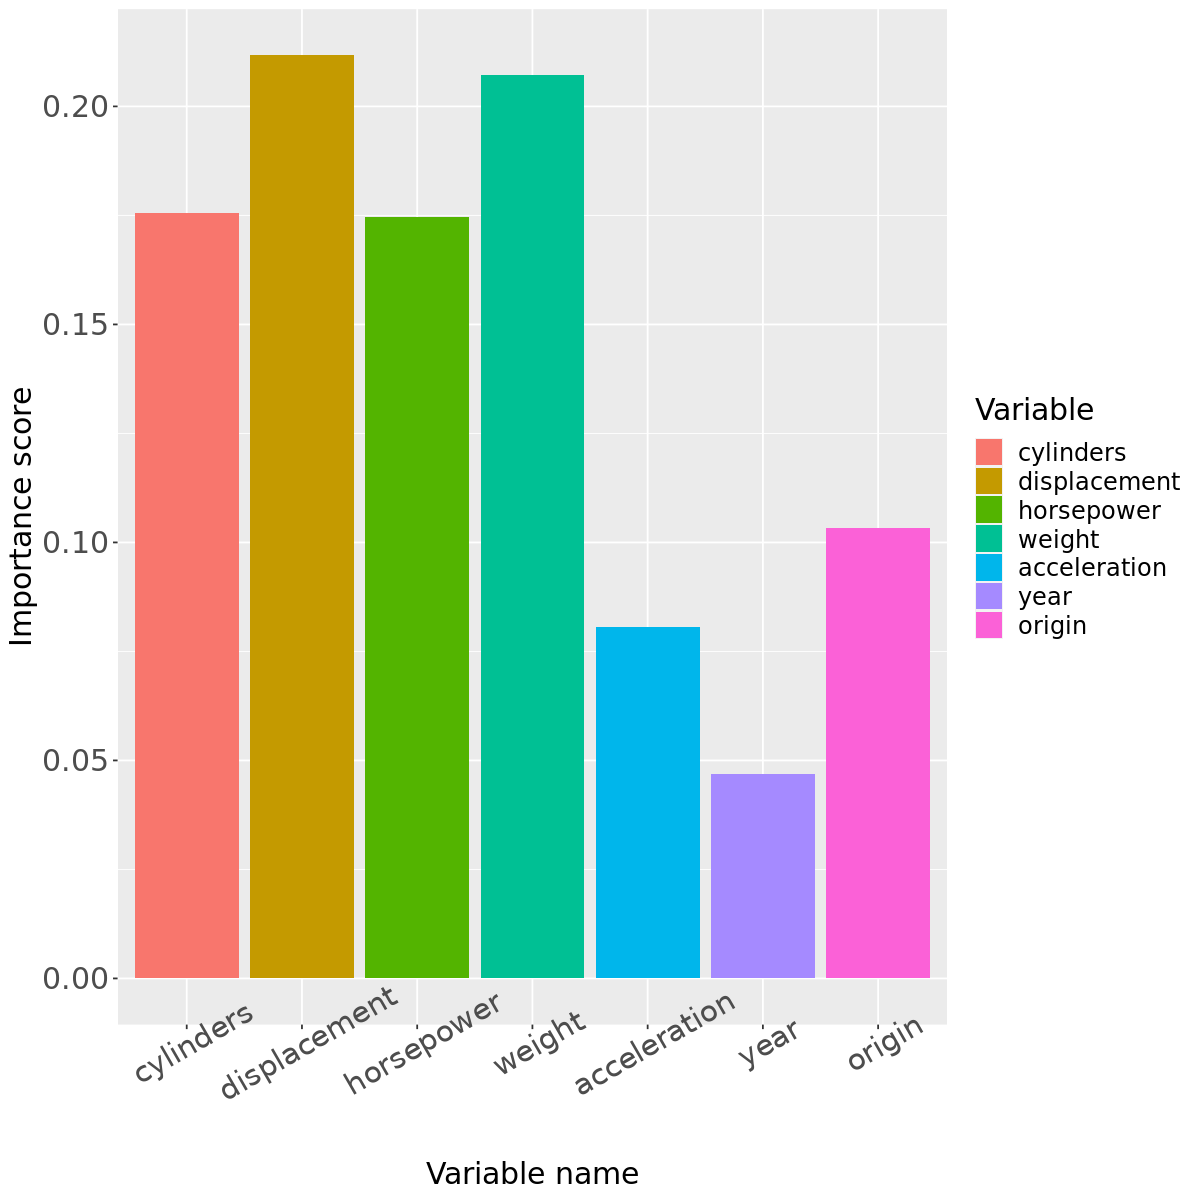

In [24]:
x_name <- factor(colnames(x), levels = colnames(x))
ggplot(data = NULL, aes(x = x_name, y = fit_GBT$variable.importance, fill = x_name)) +
    geom_col() +
    xlab("Variable name") +
    ylab("Importance score") +
    guides(fill = guide_legend(title = "Variable")) +
    theme(text = element_text(size = 18), 
          axis.title = element_text(size = 18), 
          axis.text.y = element_text(size = 18), 
          axis.text.x = element_text(size = 18, angle = 30))

### Boston housing dataset

In [25]:
# install.packages("mlbench")
library(mlbench)

data(BostonHousing)
dim(BostonHousing)
sum(is.na(BostonHousing))
head(BostonHousing)

[1] 506  14

[1] 0

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
6,0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


#### Linear regression

In [26]:
x <- BostonHousing[, 1:13]
x[, 4] <- as.numeric(x[, 4])
# head(x)

y <- BostonHousing[, 14]
# y

In [27]:
cv.lm(x, y, nfold = 10, center = FALSE, scale = FALSE)

Info: Sample size: 506

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


test loss mean: 24.0735086705176, sd of mean: 3.7810735422065



$cv_mean
[1] 24.07351

$cv_sd
[1] 3.781074

$test_loss
  fold_1   fold_2   fold_3   fold_4   fold_5   fold_6   fold_7   fold_8 
14.69371 31.47275 51.35343 22.94449 17.66414 18.56940 17.92571 12.12990 
  fold_9  fold_10 
27.69017 26.29139 

attr(,"class")
[1] "cv.lm"

#### Gradient boosting

We set `ntree_vec = c(1:100)` for all the settings of the learning rate `shrinkage`

In [28]:
x <- BostonHousing[, 1:13]
# head(x)

y <- BostonHousing[, 14]
# y

Info: Sample size: 506

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 9.40124138366635 is achieved at the 53-th iteration, corresponding sd: 1.36461521338233



GBT finished!


Info: Sample size: 506

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 8.70918220647855 is achieved at the 20-th iteration, corresponding sd: 1.11276194235321



GBT finished!


Info: Sample size: 506

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 11.0855896649855 is achieved at the 14-th iteration, corresponding sd: 2.23589206861926



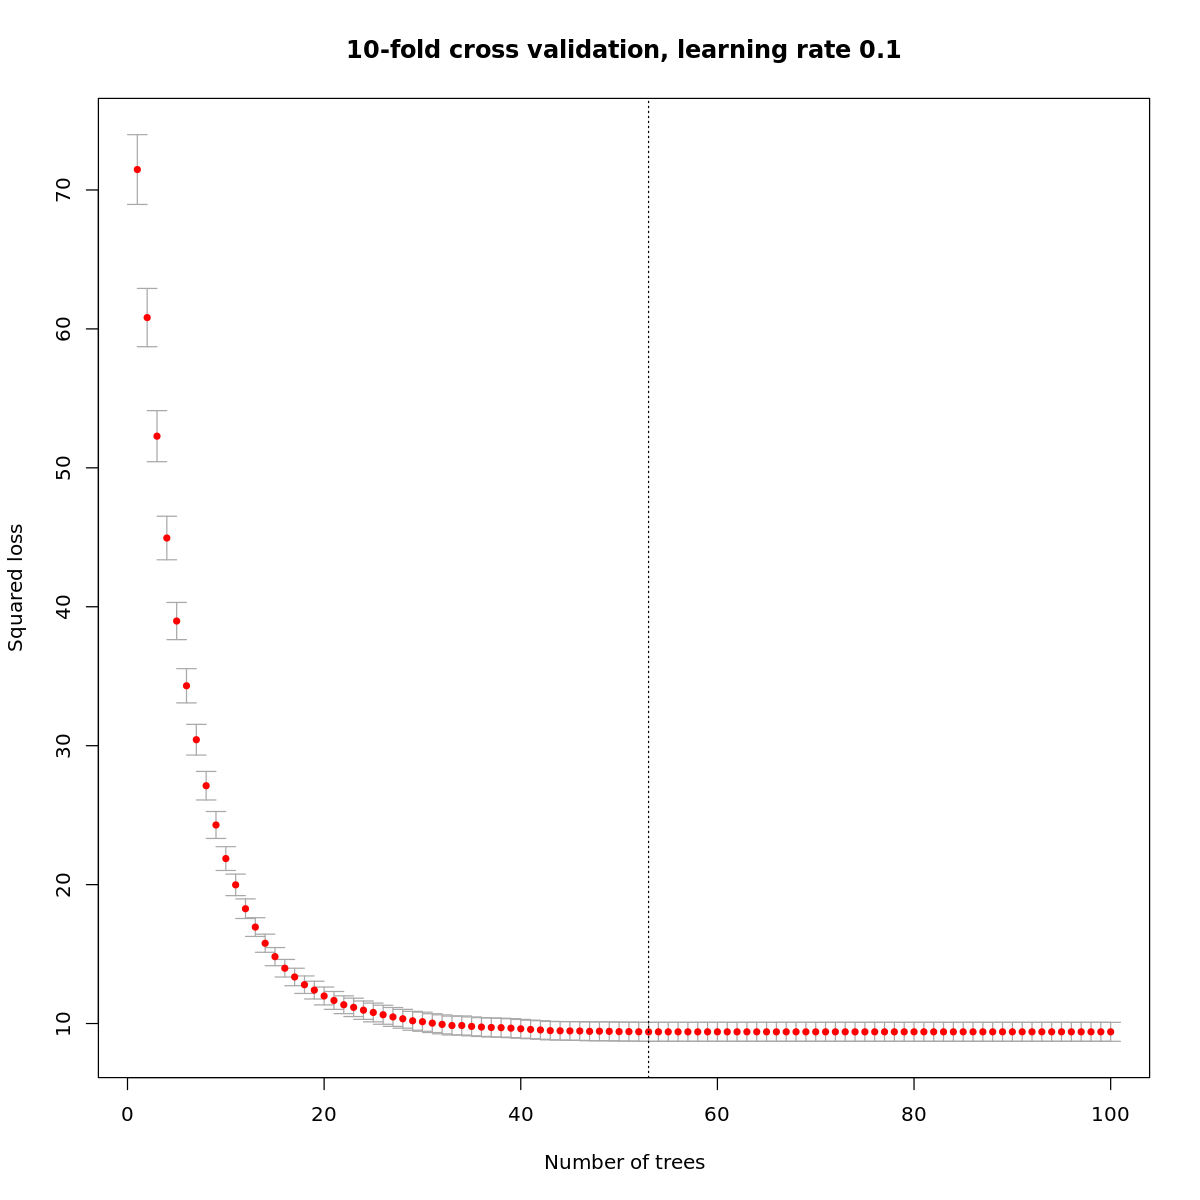

GBT finished!


Info: Sample size: 506

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 10.3011000855503 is achieved at the 14-th iteration, corresponding sd: 0.843622696813263



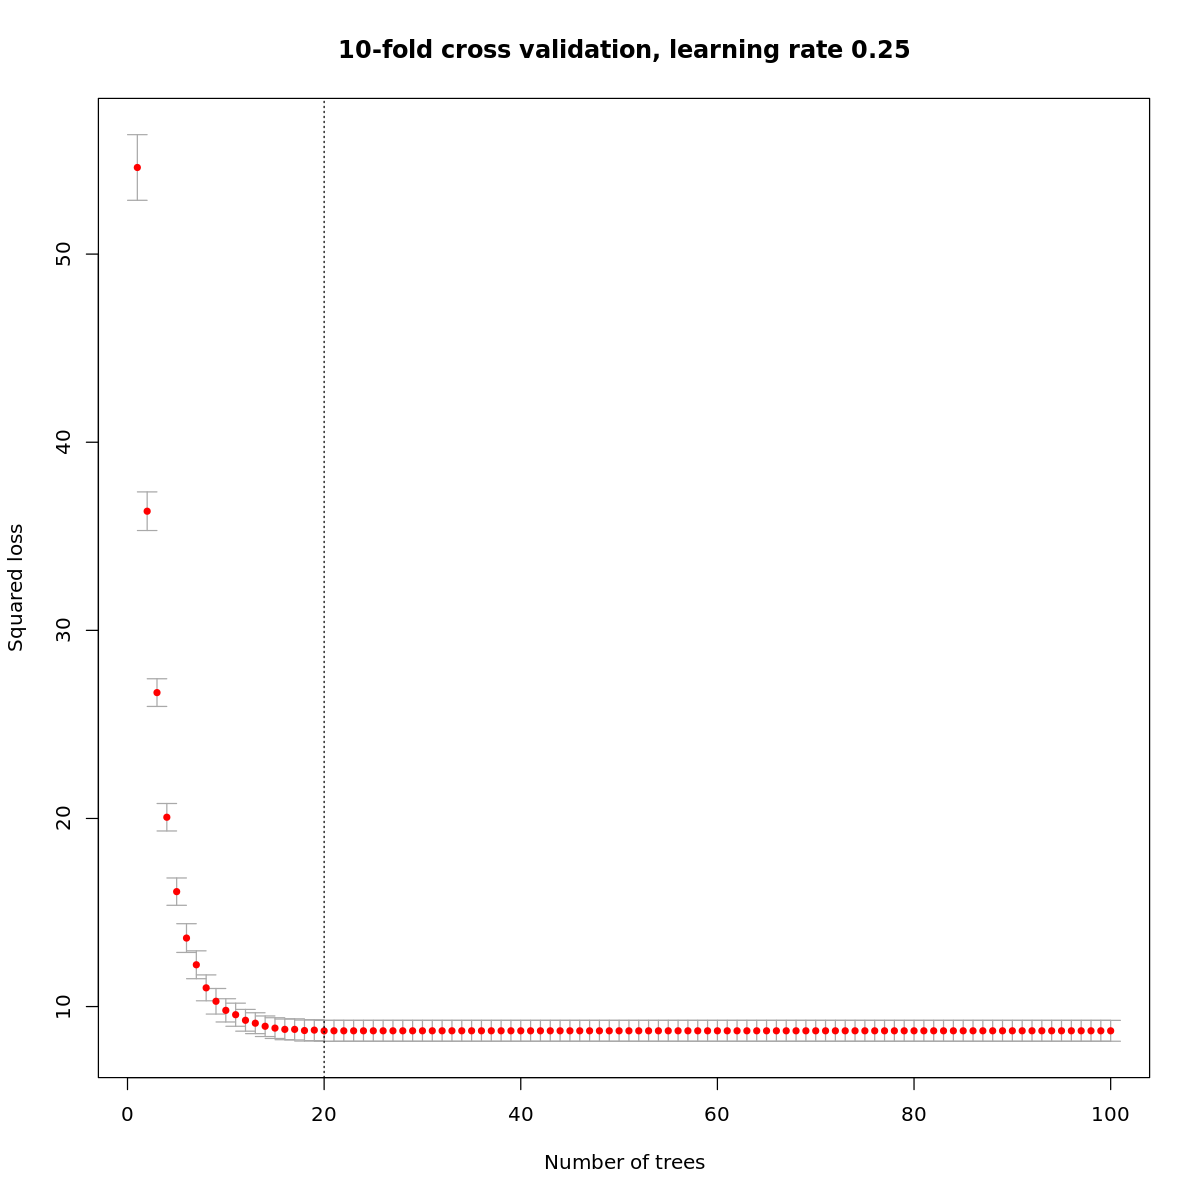

GBT finished!


Info: Sample size: 506

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 14.7009649684444 is achieved at the 5-th iteration, corresponding sd: 2.6926064710041



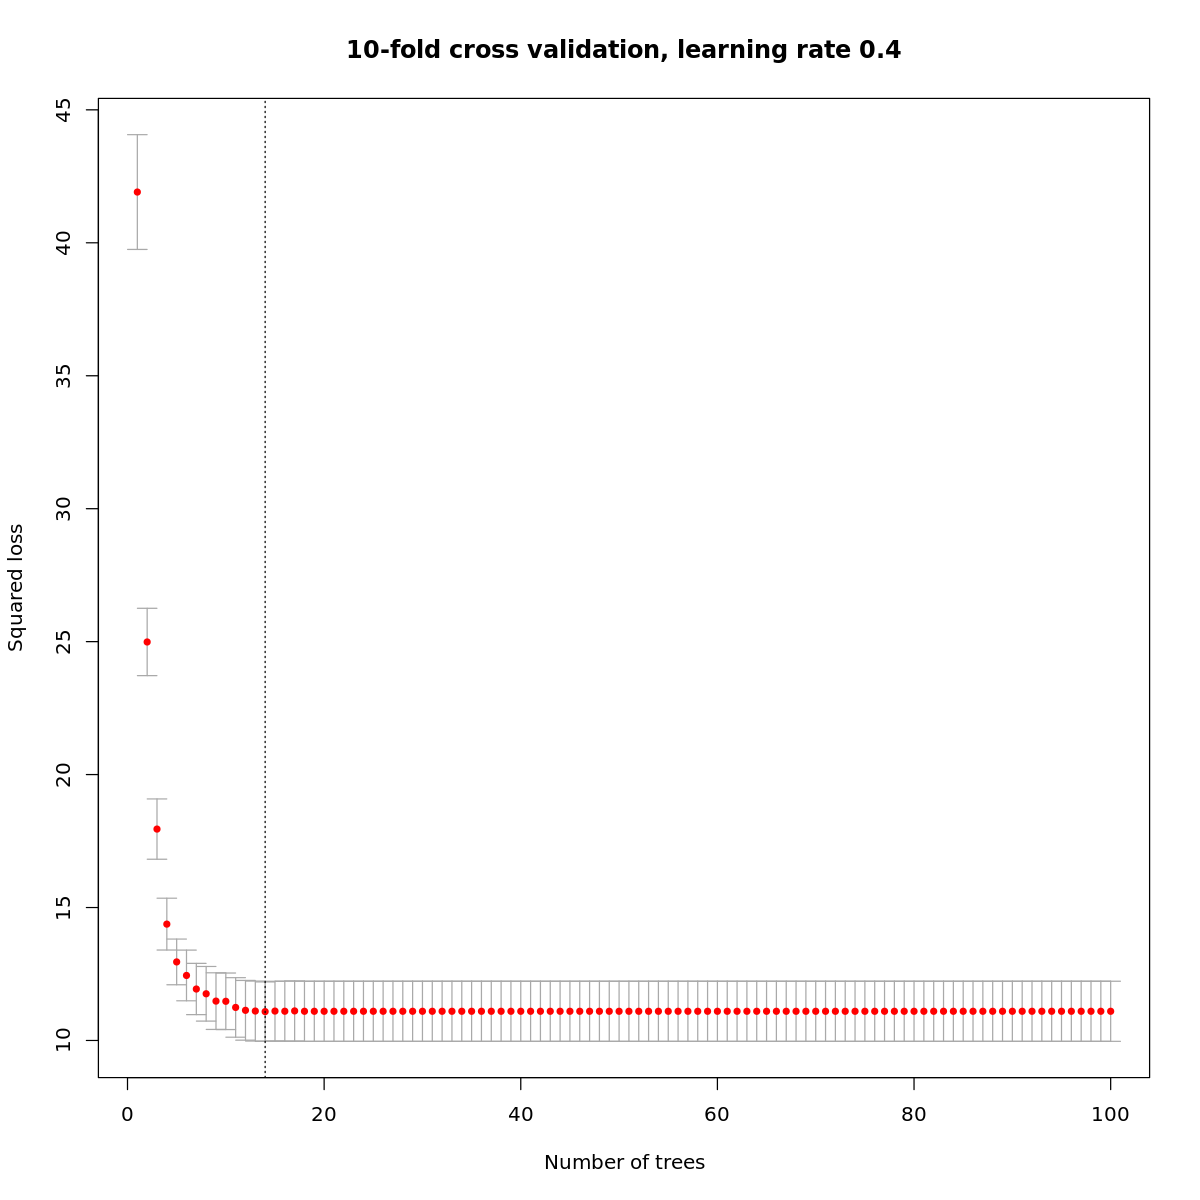

GBT finished!


Info: Sample size: 506

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 13.859860959673 is achieved at the 10-th iteration, corresponding sd: 2.21288282356816



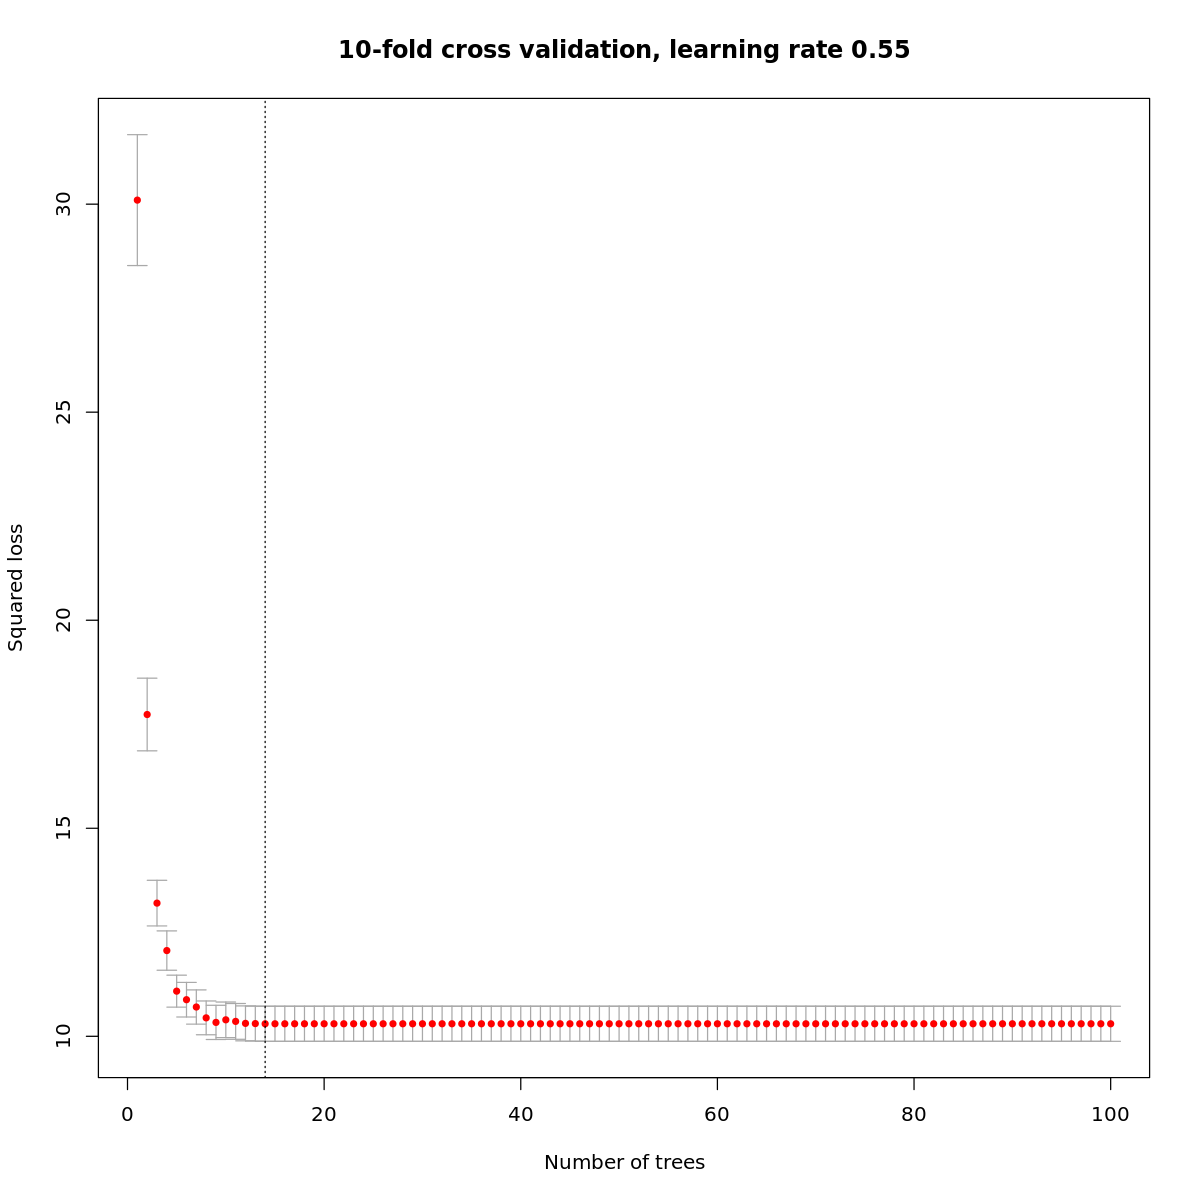

GBT finished!


Info: Sample size: 506

Info: Number of cv folds: 10



start cross validation process...... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


min test loss: 16.4815786470949 is achieved at the 9-th iteration, corresponding sd: 3.38812522193452



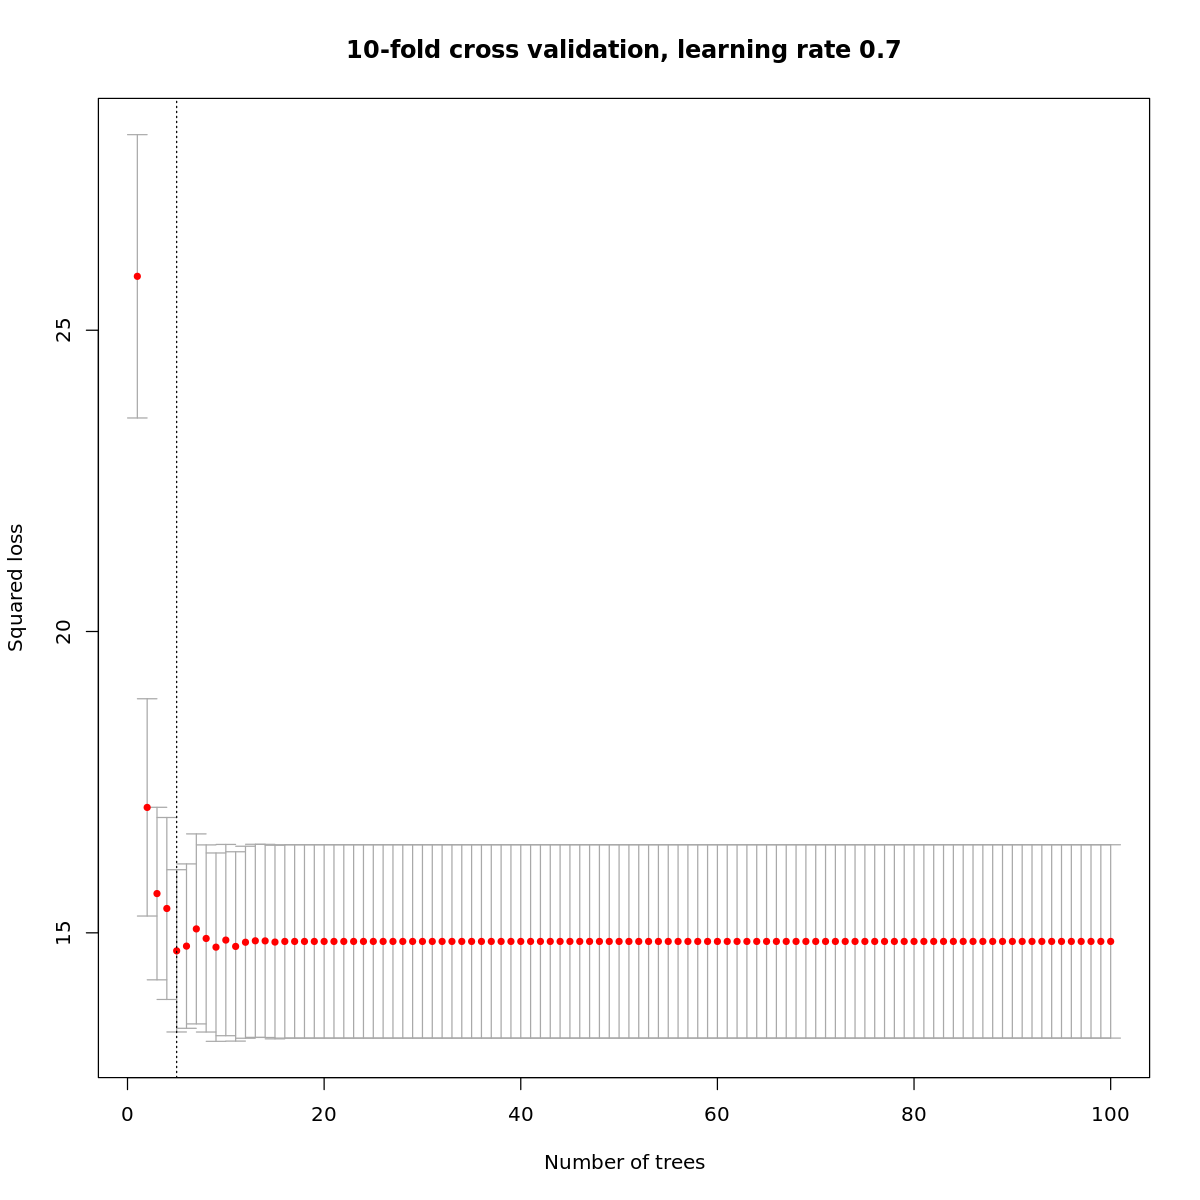

GBT finished!


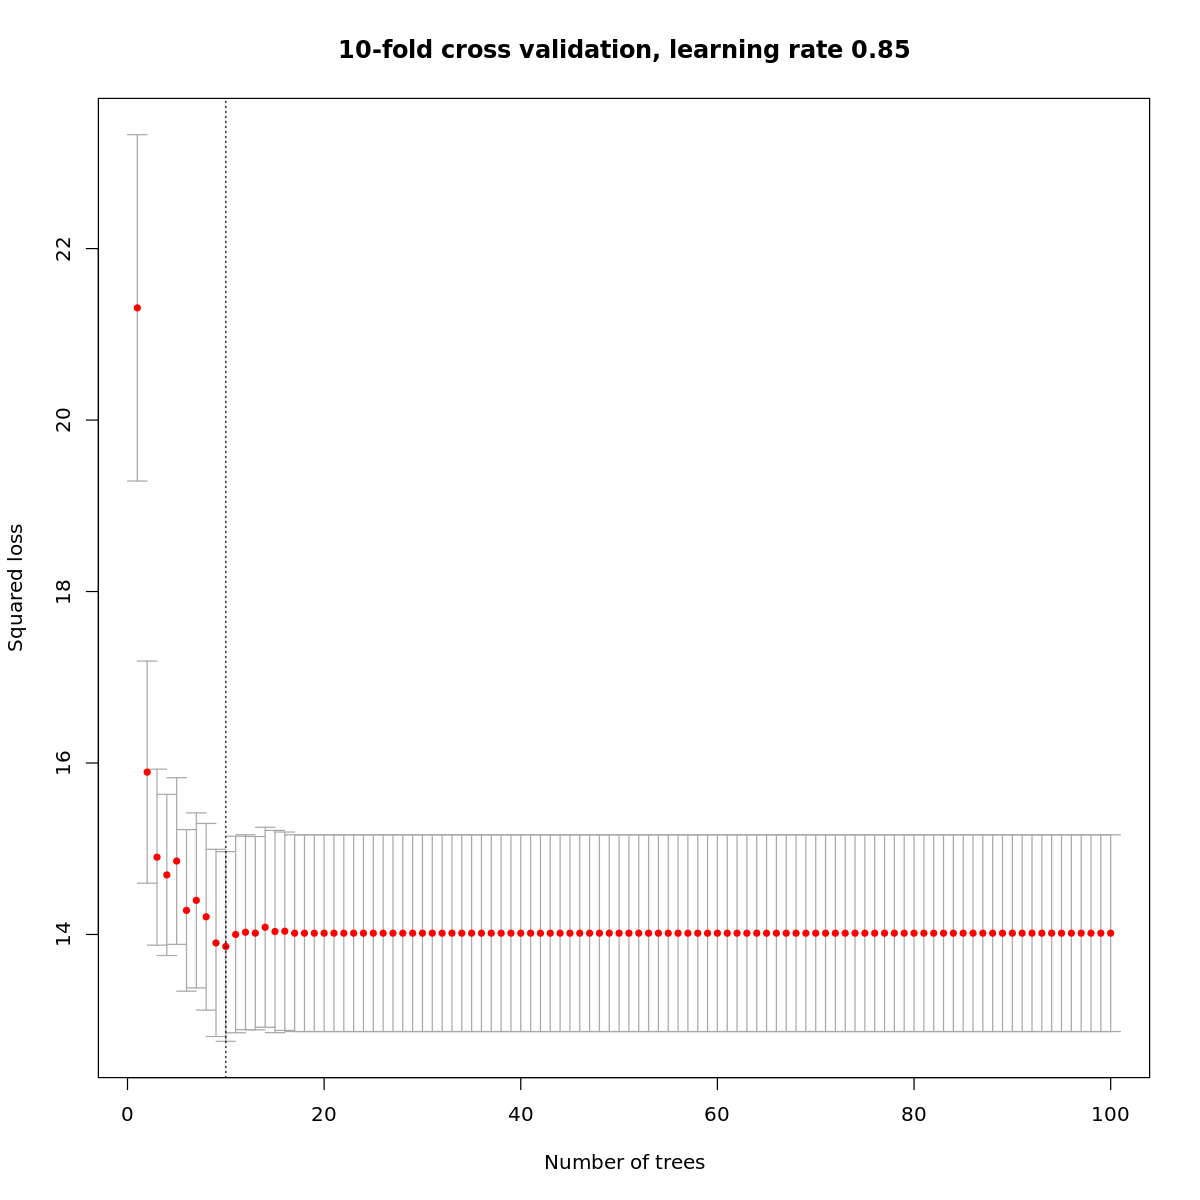

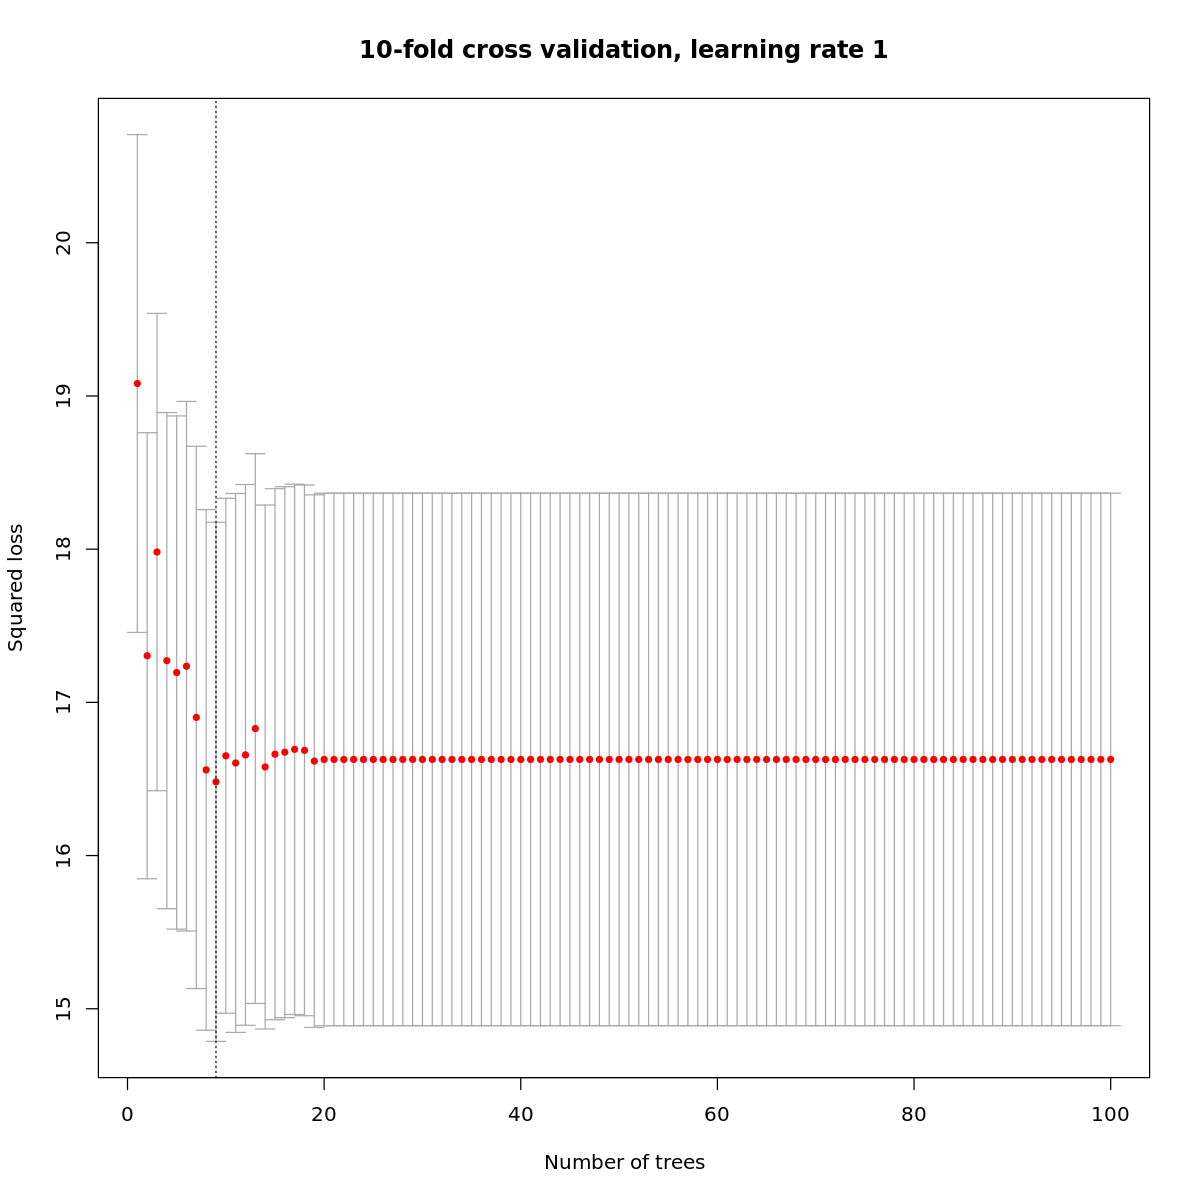

In [29]:
shrinkage_list <- seq(from = 0.1, to = 1, by = 0.15)
for(shrinkage in shrinkage_list){
    GBT_nfold_10 <- cv.GBT(x, y, ntree_vec = c(1:100), nfold = 10, shrinkage = shrinkage)
    cat("GBT finished!\n")
    plot(GBT_nfold_10, main = paste0("10-fold cross validation, learning rate ", shrinkage))
}

#### Let's put more curves together!

<font color='red'>Note: We use the same fold division here for all learning rate settings in each trial.</font>

In [30]:
x <- data.frame(x)
n <- length(y)

nfold <- 10
idx <- ceiling(sample(1:n) / n * nfold)

# # Report experiment setting
# message("Info: Sample size: ", n)
# message("Info: Number of cv folds: ", nfold)

shrinkage_vec <- c(.1, .3, .5, .9)

ntree_vec <- c(0:100)
ntree_length <- length(ntree_vec)
ntree_max <- ntree_vec[ntree_length]

cv_loss <- matrix(, nrow = length(ntree_vec), ncol = length(shrinkage_vec))

for (j in 1:length(shrinkage_vec)) {
    shrinkage <- shrinkage_vec[j]
    message(j, "-th shrinkage parameter: ", shrinkage, "...")
    
    cv_loss_j <- matrix(0, nrow = nfold, ncol = ntree_length) # Row: fold; col: number of trees
    # rownames(test_loss) <- paste0("fold_", 1:nfold)
    # colnames(test_loss) <- paste0("ntree_", ntree_vec)

    for (i in 1:nfold) {
        cat(i, "-th validation set... \n")

        x_train <- x[idx != i, ]
        y_train <- y[idx != i]

        x_test <- x[idx == i, ]
        y_test <- y[idx == i]

        # Fit the model using current training set and shrinkage parameter
        fit_GBT <- GBT(x_train, y_train,
            ntree = ntree_max, shrinkage = shrinkage
        )

        cv_loss_j[i, ] <- eval.loss.GBT(fit_GBT, x_test, y_test)[ntree_vec + 1]
    }
    
    cv_loss[, j] <- colMeans(cv_loss_j)
}

cv_loss <- data.frame(ntree_vec, cv_loss)
colnames(cv_loss)[1] <- "Number of trees"
colnames(cv_loss)[-1] <- shrinkage_vec

cv_loss <- reshape2::melt(
    data = cv_loss,
    id.vars = "Number of trees",
    variable.name = "Learning rate",
    value.name = "Squared error"
)

head(cv_loss)

1-th shrinkage parameter: 0.1...



1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


2-th shrinkage parameter: 0.3...



1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


3-th shrinkage parameter: 0.5...



1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


4-th shrinkage parameter: 0.9...



1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


,Number of trees,Learning rate,Squared error
,<int>,<fct>,<dbl>
1,0,0.1,84.68390
2,1,0.1,71.59798
3,2,0.1,60.79469
4,3,0.1,51.90679
5,4,0.1,44.76792
6,5,0.1,38.94695


Warning message:
“Removed 15 row(s) containing missing values (geom_path).”
Warning message:
“Removed 15 row(s) containing missing values (geom_path).”


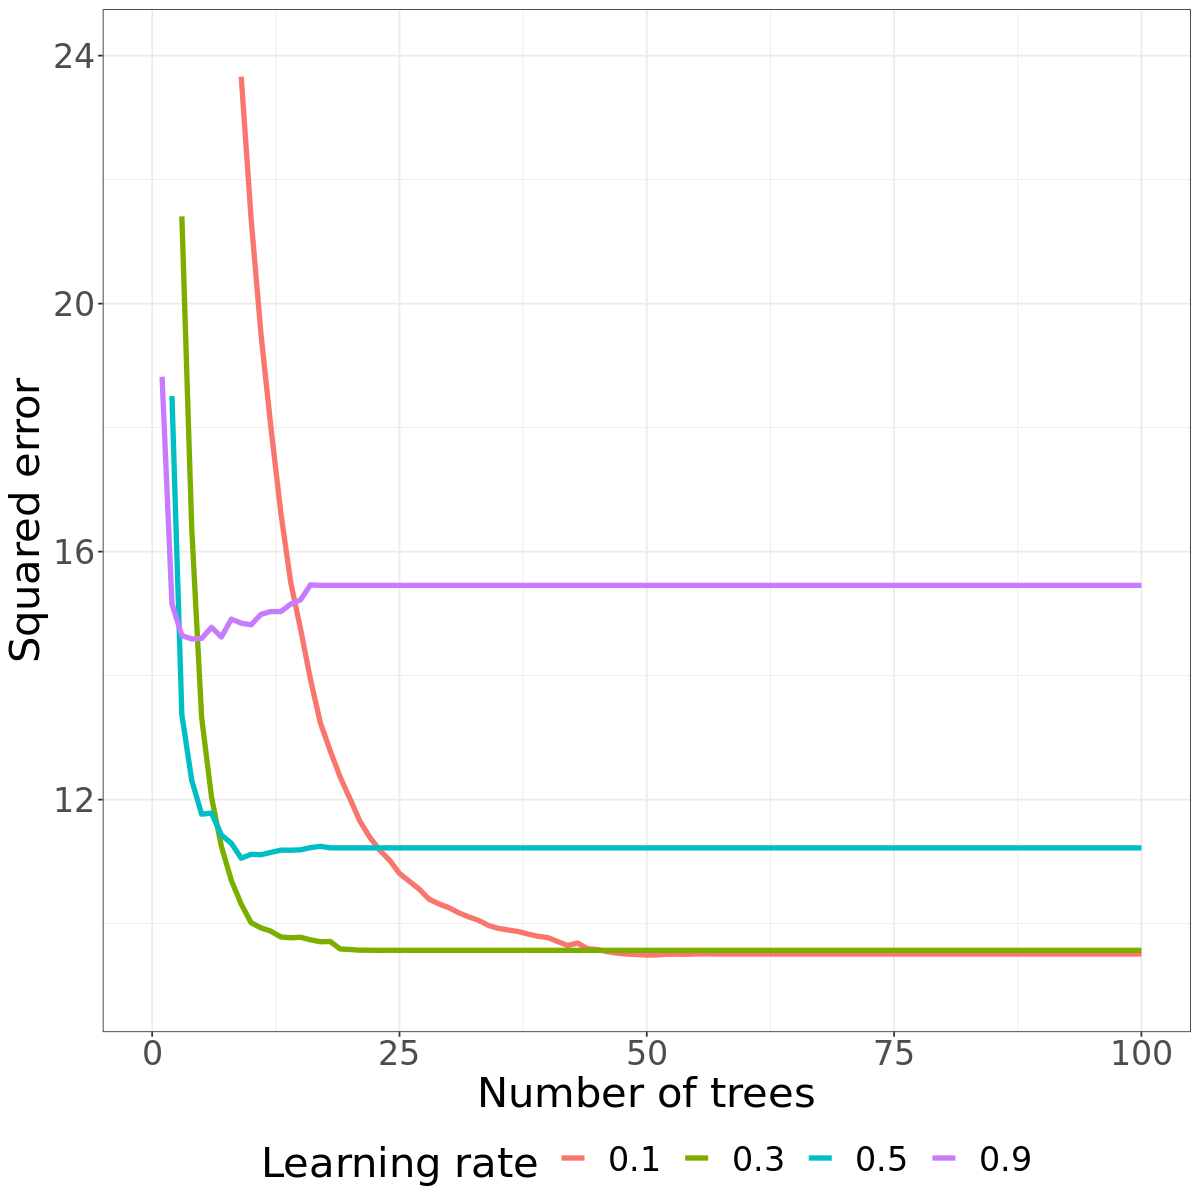

In [31]:
p <- ggplot(data = cv_loss, aes(
    x = `Number of trees`, y = `Squared error`,
    group = `Learning rate`, color = `Learning rate`
)) +
    geom_line(size = 1.5) +
    # xlab("Number of trees") +
    # ylab("Squared error") +
    # xlim(0, 50) +
    ylim(9, 24) +
    theme_bw() +
    theme(
        text = element_text(size = 25),
        axis.title = element_text(size = 25),
        legend.position = "bottom"
    )

ggsave(
    paste0(
        "./shrinkage.png"
    ),
    p,
    width = 10, height = 8
)

p

#### Variable importance

In [32]:
fit_GBT <-  GBT(x, y, shrinkage = 0.2, ntree = 30)
fit_GBT$variable.importance

crim           zn        indus         chas          nox           rm 
0.0747674585 0.0218349005 0.0938639093 0.0006245018 0.0928310401 0.2339256171 
         age          dis          rad          tax      ptratio            b 
0.0782399022 0.0753759343 0.0128062850 0.0424217744 0.0439104411 0.0076840807 
       lstat 
0.2217141552

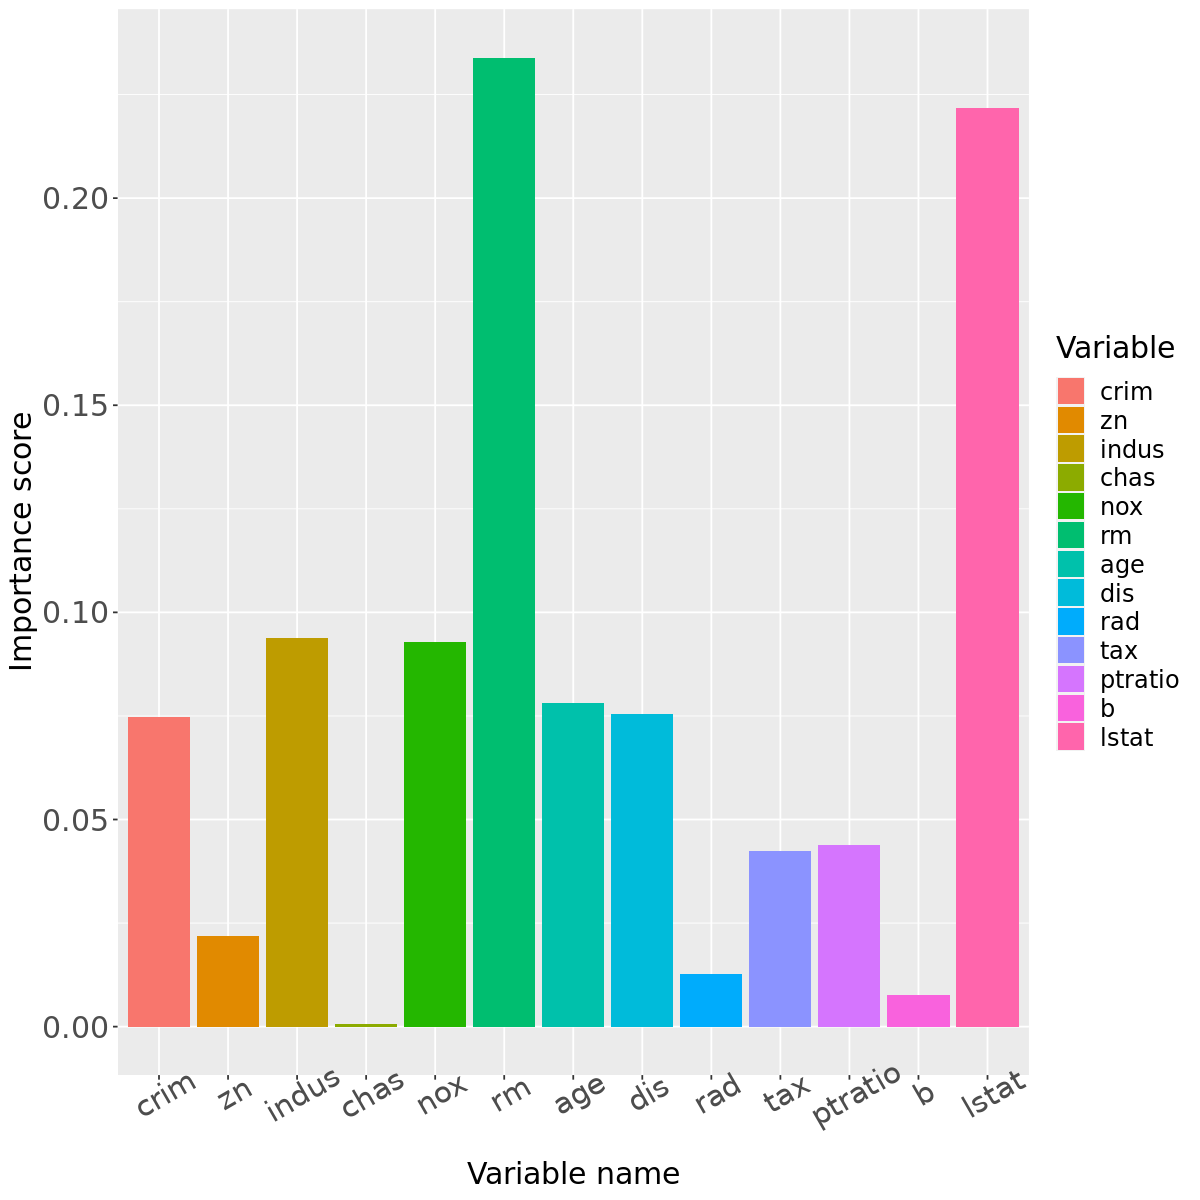

In [33]:
x_name <- factor(colnames(x), levels = colnames(x))
ggplot(data = NULL, aes(x = x_name, y = fit_GBT$variable.importance, fill = x_name)) +
    geom_col() +
    xlab("Variable name") +
    ylab("Importance score") +
    guides(fill = guide_legend(title = "Variable")) +
    theme(text = element_text(size = 18), 
          axis.title = element_text(size = 18), 
          axis.text.y = element_text(size = 18), 
          axis.text.x = element_text(size = 18, angle = 30))